In [1]:
%pip install sentinelsat
%pip install earthdata
%pip install astropy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# coding: utf-8

"""
find_matching_IS2_S2_paris.py
Written by Marco Bagnardi (04/2022)

tested with the adapted 'geo' conda env

This script searches for semi-coincident ICESat-2 and Sentinel-2 data.
It uses the Sentinel API.

For each ICESat-2 granule in a given directory (e.g., data archive on 
cooler), the sofware find Sentinel-2 images with ICESat-2 data falling
within the image's footprint.

Uses the middle strong beam but could be easily adapted to check across all beams. 

Output:
- PNG image showing the ICESat-2 granule name, the Sentinel-2 image
(or images) outline colorcoded by product name, the start and end time of
the data overlap, and the ICESat-2 footprint in black.
- TXT file with data summary and links for download of quicklook images or
full data products. Note that some of the Sentinel-2 may not be available
for direct download.
- Directory with all quicklook images of the Sentinel-2 tiles


UPDATE HISTORY:
Written 04/2022
Updated in 2023 by A Petty
Updated in June 2023 to read in data form the earthdata cloud
 - https://github.com/nsidc/NSIDC-Data-Tutorials/blob/main/notebooks/ICESat-2_Cloud_Access/nsidc_daac_uwg_cloud_access_tutorial_rendered.ipynb


To Do:

 - add support for downloading the quick-look figures. 

"""


from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import datetime as dt
import h5py
import pandas as pd
# Need to do this for geopandas for some reason
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import glob
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
from astropy.time import Time
import numpy as np
from PIL import Image
import io
import requests
import time
import earthaccess
import xarray as xr

In [3]:

# Function to download and save quicklook image to directory with IS-2 granule name
def save_quicklook(id_, username, password, dir_name, imagename):
    url = "https://apihub.copernicus.eu/apihub/odata/v1/Products('{}')/Products('Quicklook')/$value".format(id_)
    bytes_img = requests.session().get(url, auth=(username, password)).content
    ql = Image.open(io.BytesIO(bytes_img))

    ql = ql.save(dir_name + '/' + imagename + '.jpg')
    return

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/jovyan


Enter your Earthdata Login username:  akpetty
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 07/08/2023
Using user provided credentials for EDL
 Opening 639 granules, approx size: 59.67 GB


SUBMITTING | :   0%|          | 0/639 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/639 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/639 [00:00<?, ?it/s]

<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220607225935_11741501_005_02.h5>
4.563448905944824


Querying products:  45%|####4     | 100/224 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608003351_11751501_005_02.h5>
9.292532444000244


Querying products:  42%|####2     | 100/236 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608003351_11751501_005_02.h5>
2.629295587539673


Querying products:  26%|##5       | 100/388 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608020808_11761501_005_02.h5>
2.987717866897583


Querying products:  17%|#7        | 100/580 [00:00<?, ?product/s]

Number of overlapping tiles: 5
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220608T025531_N0400_R032_T55XEE_20220608T044751
S2A_MSIL1C_20220608T025531_N0400_R032_T55XDC_20220608T044751
S2A_MSIL1C_20220608T025531_N0400_R032_T55XEB_20220608T044751
S2A_MSIL1C_20220608T025531_N0400_R032_T55XDA_20220608T044751
S2A_MSIL1C_20220608T025531_N0400_R032_T54XXF_20220608T044751
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 0c966b6a-e2b3-49f8-ae75-17b9cadf5775 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product d01ab326-6087-4f6e-84cd-6e9a99b071ab is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2740dfe4-a3b0-45c8-aa7b-d8393756feee is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 9f288789-

Querying products:  22%|##1       | 100/456 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608034226_11771501_005_02.h5>
7.9742043018341064


Querying products:  26%|##6       | 100/379 [00:00<?, ?product/s]

Number of overlapping tiles: 1
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220608T043711_N0400_R033_T51XWC_20220608T053125
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 6fe94b6f-f27f-402c-a3cc-95944e0254b3 is not online.
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608051643_11781501_005_02.h5>
3.8854329586029053


Querying products:  36%|###5      | 100/281 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608051643_11781501_005_02.h5>
2.4712469577789307


Querying products:  42%|####1     | 100/240 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608065100_11791501_005_02.h5>
2.3581385612487793


Querying products:  22%|##1       | 100/457 [00:00<?, ?product/s]

Number of overlapping tiles: 8
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220608T070619_N0400_R106_T43XEB_20220608T083215
S2B_MSIL1C_20220608T070619_N0400_R106_T43XEA_20220608T083215
S2B_MSIL1C_20220608T070619_N0400_R106_T42WXB_20220608T083215
S2B_MSIL1C_20220608T070619_N0400_R106_T43WDS_20220608T083215
S2B_MSIL1C_20220608T070619_N0400_R106_T43WDR_20220608T083215
S2B_MSIL1C_20220608T070619_N0400_R106_T42WXA_20220608T083215
S2B_MSIL1C_20220608T070619_N0400_R106_T43WDQ_20220608T083215
S2B_MSIL1C_20220608T070619_N0400_R106_T42WXV_20220608T083215
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 89907c1e-675c-4a05-9473-bd2adecc259a is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a4737eb6-cf51-4faf-972d-069350d7dfea is not online.
Try downloading quicklook scenes using the API
Try downloading full scen

Querying products:  18%|#8        | 100/543 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608082518_11801501_005_02.h5>
2.5678088665008545


Querying products:  23%|##2       | 100/441 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608082518_11801501_005_02.h5>
2.7402164936065674


Querying products:  37%|###7      | 100/267 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608095935_11811501_005_02.h5>
2.9662442207336426


Querying products:  46%|####5     | 100/218 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608095935_11811501_005_02.h5>
6.764134168624878


Querying products:  34%|###3      | 100/296 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608113352_11821501_005_02.h5>
4.600444793701172


Querying products:  38%|###8      | 100/260 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608113352_11821501_005_02.h5>
3.873622179031372
Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608130809_11831501_005_02.h5>
3.984816312789917


Querying products:  38%|###7      | 100/265 [00:00<?, ?product/s]

Number of overlapping tiles: 9
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220608T134729_N0400_R110_T27XWE_20220608T160009
S2B_MSIL1C_20220608T134729_N0400_R110_T28XDJ_20220608T160009
S2B_MSIL1C_20220608T134729_N0400_R110_T27XWD_20220608T160009
S2B_MSIL1C_20220608T134729_N0400_R110_T27XWC_20220608T160009
S2B_MSIL1C_20220608T134729_N0400_R110_T28XDH_20220608T160009
S2B_MSIL1C_20220608T134729_N0400_R110_T27XWB_20220608T160009
S2B_MSIL1C_20220608T134729_N0400_R110_T28XDG_20220608T160009
S2B_MSIL1C_20220608T134729_N0400_R110_T27XWA_20220608T160009
S2B_MSIL1C_20220608T134729_N0400_R110_T27WWV_20220608T160009
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2c6848a5-d354-4c32-aa4d-c7171954a29d is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 545eb5cd-8a95-49db-a7e6-57991427c7f9 is not online.
Try downloa

User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220608T134729_N0400_R110_T28XDG_20220608T160009 (862857727 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 191abc06-2cec-4f39-bc96-f5032d2a370a is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220608T134729_N0400_R110_T27XWA_20220608T160009 (886792036 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product d9f70cff-5b10-4a6b-bcb7-819bac0f5e18 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220608T134729_N0400_R110_T27WWV_20220608T160009 (700052288 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608130809_11831501_005_02.h5>
3.638188362121582


Querying products:  29%|##8       | 100/347 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608144227_11841501_005_02.h5>
1.99003005027771


Querying products:  27%|##7       | 100/365 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608144227_11841501_005_02.h5>
2.213670015335083


Querying products:  33%|###3      | 100/299 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608161644_11851501_005_02.h5>
3.106436252593994


Querying products:  21%|##1       | 100/467 [00:00<?, ?product/s]

Number of overlapping tiles: 3
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220608T170849_N0400_R112_T19XEB_20220608T191919
S2B_MSIL1C_20220608T170849_N0400_R112_T19XEC_20220608T191919
S2A_MSIL1C_20220608T161841_N0400_R040_T19VDK_20220608T212227
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product cb4cb0be-ecd4-4aab-bed2-c0b29b7997b8 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220608T170849_N0400_R112_T19XEB_20220608T191919 (750575484 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 324beb7d-cf0a-4f25-a286-ead22b89e796 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220608T170849_N0400_R112_T19XEC_20220608T191919 (748060869 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 84f9210f-f576-4876-b8c0-8db44c9a2aa6 is online. Starting download.


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608161644_11851501_005_02.h5>
2.2760870456695557


Querying products:  18%|#8        | 100/554 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608175101_11861501_005_02.h5>
5.317025899887085


Querying products:  20%|##        | 100/499 [00:00<?, ?product/s]

Number of overlapping tiles: 3
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220608T184919_N0400_R113_T16XEM_20220608T204720
S2B_MSIL1C_20220608T184919_N0400_R113_T16XDK_20220608T204720
S2A_MSIL1C_20220608T175921_N0400_R041_T15WWT_20220608T215013
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 56353e33-3065-4b03-91c5-8d1807cea843 is online. Starting download.


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 70aa90db-9aaf-46da-ba8d-1e4854817647 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220608T184919_N0400_R113_T16XDK_20220608T204720 (699684010 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 06286525-aa0a-4888-a4ea-6cfdff927fdf is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220608T175921_N0400_R041_T15WWT_20220608T215013 (861396364 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608175101_11861501_005_02.h5>
0.4232001304626465


Querying products:  43%|####2     | 100/233 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608192519_11871501_005_02.h5>
3.1817915439605713


Querying products:  61%|######    | 100/165 [00:00<?, ?product/s]

Number of overlapping tiles: 1
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220608T193911_N0400_R042_T12XVG_20220608T225800
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 79e1a950-47fb-4daf-bd7a-df589667074c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220608T193911_N0400_R042_T12XVG_20220608T225800 (584882318 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608192519_11871501_005_02.h5>
3.518946409225464


Querying products:  45%|####5     | 100/222 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608205936_11881501_005_02.h5>
2.3378496170043945


Querying products:  35%|###4      | 100/286 [00:00<?, ?product/s]

Number of overlapping tiles: 4
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220608T212531_N0400_R043_T07WFU_20220608T232502
S2A_MSIL1C_20220608T212531_N0400_R043_T07WFT_20220608T232502
S2A_MSIL1C_20220608T212531_N0400_R043_T07WFS_20220608T232502
S2A_MSIL1C_20220608T212531_N0400_R043_T07WES_20220608T232502
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 5ac033fe-376f-417d-940f-08040680e565 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220608T212531_N0400_R043_T07WFU_20220608T232502 (307984880 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product b9d88d8b-e521-455a-8f20-2e17d9d5dec7 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220608T212531_N0400_R043_T07WFT_20220608T232502 (705974316 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 0753c765-0c27-46e1-84c7-641df97bf430 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220608T212531_N0400_R043_T07WFS_20220608T232502 (390880142 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 1c2a4672-0893-4d59-b07e-e5140800a53c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220608T212531_N0400_R043_T07WES_20220608T232502 (766841254 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608205936_11881501_005_02.h5>
2.9718518257141113


Querying products:  37%|###6      | 100/273 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-01_20220608223353_11891501_005_01.h5>
2.447293996810913


Querying products:  44%|####4     | 100/227 [00:00<?, ?product/s]

Number of overlapping tiles: 4
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220608T230541_N0400_R044_T03XXA_20220609T003445
S2A_MSIL1C_20220608T230541_N0400_R044_T04XDF_20220609T003445
S2A_MSIL1C_20220608T230541_N0400_R044_T04WDE_20220609T003445
S2A_MSIL1C_20220608T230541_N0400_R044_T03WXV_20220609T003445
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 275efea3-5ade-4dee-b961-2ba15f9ce054 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220608T230541_N0400_R044_T03XXA_20220609T003445 (562690264 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2c958c78-02de-4e4b-9553-c0cf0148399d is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220608T230541_N0400_R044_T04XDF_20220609T003445 (519079932 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 40739bbb-2a33-48f1-ae93-6905cdfd6cea is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220608T230541_N0400_R044_T04WDE_20220609T003445 (779690457 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 37493bbf-c1ff-470e-9e53-9d188cb55bfc is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220608T230541_N0400_R044_T03WXV_20220609T003445 (782037610 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/08/ATL07-02_20220608223353_11891501_005_01.h5>
4.842482805252075


Querying products:  40%|####      | 100/247 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609000813_11901501_005_01.h5>
8.43348479270935


Querying products:  42%|####2     | 100/237 [00:00<?, ?product/s]

Number of overlapping tiles: 4
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220609T004651_N0400_R045_T59WPT_20220609T005837
S2A_MSIL1C_20220609T004651_N0400_R045_T60WVC_20220609T005837
S2A_MSIL1C_20220609T004651_N0400_R045_T60WVD_20220609T005837
S2A_MSIL1C_20220609T004651_N0400_R045_T59WPU_20220609T005837
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a5cfc711-cfd3-4095-9d37-40d3786b7334 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T004651_N0400_R045_T59WPT_20220609T005837 (149063207 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product b34665ad-563d-4c9f-8e97-300e81595076 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T004651_N0400_R045_T60WVC_20220609T005837 (27988927 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 850ce27c-9082-446f-b985-a2c56485cfd5 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T004651_N0400_R045_T60WVD_20220609T005837 (16998066 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 1e123319-0209-4c35-8217-dc15155ff5b4 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T004651_N0400_R045_T59WPU_20220609T005837 (69166664 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609014932_11911502_005_01.h5>
3.8705127239227295


Querying products:  21%|##        | 100/486 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609031648_11921501_005_01.h5>
4.2176513671875


Querying products:  23%|##3       | 100/434 [00:00<?, ?product/s]

Number of overlapping tiles: 9
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220609T040551_N0400_R047_T52XEM_20220609T060250
S2A_MSIL1C_20220609T040551_N0400_R047_T53XMG_20220609T060250
S2A_MSIL1C_20220609T040551_N0400_R047_T52XEL_20220609T060250
S2A_MSIL1C_20220609T040551_N0400_R047_T53XMF_20220609T060250
S2A_MSIL1C_20220609T040551_N0400_R047_T52XEK_20220609T060250
S2A_MSIL1C_20220609T040551_N0400_R047_T52XEH_20220609T060250
S2A_MSIL1C_20220609T040551_N0400_R047_T52XDH_20220609T060250
S2A_MSIL1C_20220609T040551_N0400_R047_T52XDG_20220609T060250
S2A_MSIL1C_20220609T040551_N0400_R047_T52XEG_20220609T060250
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product d4b407a1-6ed0-4203-9179-c4cf760c654a is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T040551_N0400_R047_T52XEM_20220609T060250 (356574909 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 0fcceadd-1820-4cab-bdaf-4db557f5ff1b is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T040551_N0400_R047_T53XMG_20220609T060250 (567118111 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 7f3b219c-608b-4fd5-a553-caa4d31f85d6 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T040551_N0400_R047_T52XEL_20220609T060250 (820229446 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 3357b1a6-8faa-48ab-a54f-4baf9c6c1fa8 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T040551_N0400_R047_T53XMF_20220609T060250 (814995920 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a97bd8c0-30cb-4b4f-9ca4-2b8263712baa is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T040551_N0400_R047_T52XEK_20220609T060250 (690791887 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a87d876c-f69c-4d20-982c-0f9d8f61261c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T040551_N0400_R047_T52XEH_20220609T060250 (771559969 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 239c8b91-baef-40f4-8b71-6e6aae5a563c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T040551_N0400_R047_T52XDH_20220609T060250 (666749820 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product c4630aed-1e0a-4288-a34b-835fa9839a17 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T040551_N0400_R047_T52XDG_20220609T060250 (820809164 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 79d9dd24-9fb7-4c5b-aeee-de8411d03462 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T040551_N0400_R047_T52XEG_20220609T060250 (696545806 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609031648_11921501_005_01.h5>
2.3002777099609375


Querying products:  50%|#####     | 100/199 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609045105_11931501_005_01.h5>
5.338870525360107


Querying products:  20%|##        | 100/488 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609045105_11931501_005_01.h5>
1.9939842224121094


Querying products:  20%|#9        | 100/502 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609062523_11941501_005_01.h5>
2.681075096130371


Querying products:  27%|##7       | 100/368 [00:00<?, ?product/s]

Number of overlapping tiles: 5
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220609T063629_N0400_R120_T44XMF_20220609T065520
S2B_MSIL1C_20220609T063629_N0400_R120_T43XFA_20220609T065520
S2B_MSIL1C_20220609T063629_N0400_R120_T44WNE_20220609T065520
S2B_MSIL1C_20220609T063629_N0400_R120_T44WME_20220609T065520
S2B_MSIL1C_20220609T063629_N0400_R120_T43WFV_20220609T065520
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product c01500f6-e7e9-4383-a262-03001a2bf95a is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T063629_N0400_R120_T44XMF_20220609T065520 (69538270 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 3c284c5e-3acf-4aa5-b95f-a10d783b8f76 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T063629_N0400_R120_T43XFA_20220609T065520 (74850515 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 52ac9188-b8b5-47f2-9af4-0e3ad8f7f5b6 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T063629_N0400_R120_T44WNE_20220609T065520 (795356536 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product e3d18984-f758-4655-8c94-59c01c1917e6 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T063629_N0400_R120_T44WME_20220609T065520 (490503373 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product ef919a3e-8960-47e2-a27d-8fcebff0b6f2 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T063629_N0400_R120_T43WFV_20220609T065520 (407346799 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609062523_11941501_005_01.h5>
2.158630847930908


Querying products:  19%|#9        | 100/514 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609075940_11951501_005_01.h5>
3.413516044616699


Querying products:  20%|##        | 100/489 [00:00<?, ?product/s]

Number of overlapping tiles: 7
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220609T081609_N0400_R121_T40XEG_20220609T084122
S2B_MSIL1C_20220609T081609_N0400_R121_T40XEH_20220609T084122
S2B_MSIL1C_20220609T081609_N0400_R121_T40XEF_20220609T084122
S2B_MSIL1C_20220609T081609_N0400_R121_T40WEE_20220609T084122
S2B_MSIL1C_20220609T081609_N0400_R121_T40WDE_20220609T084122
S2B_MSIL1C_20220609T081609_N0400_R121_T40WED_20220609T084122
S2B_MSIL1C_20220609T081609_N0400_R121_T40WDD_20220609T084122
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 93f1f32b-6264-4d0a-9527-038e6105f414 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T081609_N0400_R121_T40XEG_20220609T084122 (811712677 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 89fa9a81-c21d-45fb-8b89-3711941b21f5 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T081609_N0400_R121_T40XEH_20220609T084122 (334797207 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 76ea277c-262d-4103-be06-7309e4cb4908 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T081609_N0400_R121_T40XEF_20220609T084122 (882571533 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2c392fdf-f9d8-4ec4-82e6-07bf91a64702 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T081609_N0400_R121_T40WEE_20220609T084122 (881094836 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 26789ad6-14b7-4f70-9935-ac629d9a7170 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T081609_N0400_R121_T40WDE_20220609T084122 (837076870 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product e6b72867-0aef-4861-8df6-9d825f372d7f is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T081609_N0400_R121_T40WED_20220609T084122 (861467124 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product bdf9fe97-aaa7-49b2-9435-568919294605 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T081609_N0400_R121_T40WDD_20220609T084122 (862691432 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609075940_11951501_005_01.h5>
2.2682347297668457


Querying products:  30%|###       | 100/329 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609093358_11961501_005_01.h5>
2.681431770324707


Querying products:  44%|####4     | 100/227 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609093358_11961501_005_01.h5>
7.054157257080078


Querying products:  33%|###3      | 100/303 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609110815_11971501_005_01.h5>
5.87252140045166


Querying products:  76%|#######6  | 100/131 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609110815_11971501_005_01.h5>
7.048816204071045


Querying products:  40%|###9      | 100/252 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609124232_11981501_005_01.h5>
6.195828437805176


Querying products:  65%|######4   | 100/154 [00:00<?, ?product/s]

Number of overlapping tiles: 7
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220609T131719_N0400_R124_T29XME_20220609T134233
S2B_MSIL1C_20220609T131719_N0400_R124_T28XEK_20220609T134233
S2B_MSIL1C_20220609T131719_N0400_R124_T28XEJ_20220609T134233
S2B_MSIL1C_20220609T131719_N0400_R124_T29XMD_20220609T134233
S2B_MSIL1C_20220609T131719_N0400_R124_T28XEH_20220609T134233
S2B_MSIL1C_20220609T131719_N0400_R124_T29XMC_20220609T134233
S2B_MSIL1C_20220609T131719_N0400_R124_T28XEG_20220609T134233
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product f8390c1e-9908-4ac9-8099-2719a9702db6 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T131719_N0400_R124_T29XME_20220609T134233 (847326701 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 90dde7a9-f3ed-4f0a-8b7e-02a0a3d9408c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T131719_N0400_R124_T28XEK_20220609T134233 (317826310 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 66c6dc0b-663c-4c60-be7d-d361fddae719 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T131719_N0400_R124_T28XEJ_20220609T134233 (874991284 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 7a823e0d-be4f-45ff-84be-f8918b98a4a4 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T131719_N0400_R124_T29XMD_20220609T134233 (888134716 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product ed7a6092-65d2-4239-b575-52a60828df70 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T131719_N0400_R124_T28XEH_20220609T134233 (884606960 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 6e1a327a-7f55-42fc-a8c2-bd36cc5d30b3 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T131719_N0400_R124_T29XMC_20220609T134233 (840458588 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 37945dc4-8964-4c88-861d-670ce7de0fa8 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T131719_N0400_R124_T28XEG_20220609T134233 (878417481 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609124232_11981501_005_01.h5>
3.121257781982422


Querying products:  20%|##        | 100/497 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609141650_11991501_005_01.h5>
4.339555025100708


Querying products:  19%|#8        | 100/529 [00:00<?, ?product/s]

Number of overlapping tiles: 2
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220609T140741_N0400_R053_T24WVT_20220609T192902
S2A_MSIL1C_20220609T140741_N0400_R053_T24WVS_20220609T192902
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product efab4336-ccd2-40c8-bcd2-ca905f2448e8 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T140741_N0400_R053_T24WVT_20220609T192902 (624195187 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product ca3832c5-1f79-440f-b009-94c74a6f0136 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T140741_N0400_R053_T24WVS_20220609T192902 (778900716 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609141650_11991501_005_01.h5>
6.4810967445373535


Querying products:  25%|##4       | 100/402 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609155107_12001501_005_01.h5>
4.638921022415161


Querying products:  23%|##2       | 100/435 [00:00<?, ?product/s]

Number of overlapping tiles: 5
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220609T163839_N0400_R126_T20XNG_20220609T184018
S2A_MSIL1C_20220609T154821_N0400_R054_T20WNT_20220609T205424
S2A_MSIL1C_20220609T154821_N0400_R054_T20WMT_20220609T205424
S2A_MSIL1C_20220609T154821_N0400_R054_T20WNS_20220609T205424
S2A_MSIL1C_20220609T154821_N0400_R054_T20WMS_20220609T205424
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product bab2ca4b-a725-46bd-860b-a15132ad8537 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T163839_N0400_R126_T20XNG_20220609T184018 (724191252 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 0b797f98-eb98-45df-a0cf-9877545b134e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T154821_N0400_R054_T20WNT_20220609T205424 (809956037 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 98d57b84-2ac5-4a09-9371-69f039837ab3 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T154821_N0400_R054_T20WMT_20220609T205424 (871082188 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product d65868e6-ca87-4558-bad0-485100838518 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T154821_N0400_R054_T20WNS_20220609T205424 (832455749 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product c7aca8ec-f398-436e-87cd-31f74962a544 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T154821_N0400_R054_T20WMS_20220609T205424 (855315606 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609155107_12001501_005_01.h5>
1.7595229148864746


Querying products:  19%|#8        | 100/537 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609172524_12011501_005_01.h5>
5.780074596405029


Querying products:  18%|#7        | 100/558 [00:00<?, ?product/s]

Number of overlapping tiles: 10
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220609T181919_N0400_R127_T17XME_20220609T200346
S2B_MSIL1C_20220609T181919_N0400_R127_T17XMC_20220609T200346
S2A_MSIL1C_20220609T172911_N0400_R055_T16WEU_20220610T074740
S2A_MSIL1C_20220609T172911_N0400_R055_T16WET_20220610T074740
S2A_MSIL1C_20220609T172911_N0400_R055_T16WES_20220610T074740
S2A_MSIL1C_20220609T172911_N0400_R055_T16WDS_20220610T074740
S2A_MSIL1C_20220609T172911_N0400_R055_T16VDR_20220610T074740
S2A_MSIL1C_20220609T172911_N0400_R055_T16VER_20220610T074740
S2A_MSIL1C_20220609T172911_N0400_R055_T16VDQ_20220610T074740
S2A_MSIL1C_20220609T172911_N0400_R055_T16VDP_20220610T074740
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 176367d3-a9b0-4bc8-9a16-a1ab1c0420ad is online. Starting download.


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product da60430e-43bf-4cea-b126-e143e18c851e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220609T181919_N0400_R127_T17XMC_20220609T200346 (749105901 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 4973d985-3d96-4e6d-b571-ff5759a1ee1c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T172911_N0400_R055_T16WEU_20220610T074740 (897009379 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a0555c2f-d5a6-44a4-9b46-6ce3af86c6b7 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T172911_N0400_R055_T16WET_20220610T074740 (886986387 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a8f3c336-3a58-4bb2-934d-6074be3a2929 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T172911_N0400_R055_T16WES_20220610T074740 (776712768 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product ccb1c2b6-0702-4b6a-b0d4-16c266b74b05 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T172911_N0400_R055_T16WDS_20220610T074740 (837032950 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 11825953-37a6-4bdb-8606-c189ae33a8e3 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T172911_N0400_R055_T16VDR_20220610T074740 (739576445 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 1754f375-9f4b-48cf-8609-6c649315d3aa is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T172911_N0400_R055_T16VER_20220610T074740 (501315048 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product e7cb527f-62b2-4353-ba2e-ea32598c782e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T172911_N0400_R055_T16VDQ_20220610T074740 (784962070 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 6f57de57-cc82-4e69-9cf5-8534fdd7697c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220609T172911_N0400_R055_T16VDP_20220610T074740 (614205273 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609172524_12011501_005_01.h5>
2.28566312789917


Querying products:  34%|###3      | 100/298 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609185942_12021501_005_01.h5>
3.635648488998413


Querying products:  43%|####2     | 100/234 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609203359_12031501_005_01.h5>
2.896129608154297


Querying products:  31%|###       | 100/324 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-01_20220609220817_12041501_005_01.h5>
2.3078415393829346


Querying products:  33%|###2      | 100/304 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/09/ATL07-02_20220609220817_12041501_005_01.h5>
7.484695672988892


Querying products:  30%|##9       | 100/338 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220609234234_12051501_005_01.h5>
4.831305742263794


Querying products:  21%|##        | 100/477 [00:00<?, ?product/s]

Number of overlapping tiles: 6
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220610T001621_N0400_R059_T01WDV_20220610T075859
S2A_MSIL1C_20220610T001621_N0400_R059_T01XDA_20220610T075859
S2A_MSIL1C_20220610T001621_N0400_R059_T01WDU_20220610T075859
S2A_MSIL1C_20220610T001621_N0400_R059_T01WDT_20220610T075859
S2A_MSIL1C_20220610T001621_N0400_R059_T01WCT_20220610T075859
S2A_MSIL1C_20220610T001621_N0400_R059_T01WCS_20220610T075859
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 19a3e0d5-e7f5-47fb-af7b-a88ab538849e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T001621_N0400_R059_T01WDV_20220610T075859 (813124718 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 3a2a068c-eb36-4ac5-8ae1-b12e01c9ad70 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T001621_N0400_R059_T01XDA_20220610T075859 (87215870 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product bccd2e53-670d-4133-88a9-85e81711e009 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T001621_N0400_R059_T01WDU_20220610T075859 (788313467 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 453ffe46-faa1-4eab-bdff-b17632d57527 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T001621_N0400_R059_T01WDT_20220610T075859 (456757162 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a50f5b98-382f-4af3-ba65-84923040eecb is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T001621_N0400_R059_T01WCT_20220610T075859 (845610312 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product ecc026a4-31d9-4964-b147-13f9ce6fcb2f is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T001621_N0400_R059_T01WCS_20220610T075859 (766307409 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220609234234_12051501_005_01.h5>
5.278975248336792


Querying products:  23%|##3       | 100/432 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610011647_12061501_005_01.h5>
5.0524001121521


Querying products:  28%|##7       | 100/363 [00:00<?, ?product/s]

Number of overlapping tiles: 4
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220610T015701_N0400_R060_T56WPE_20220610T034707
S2A_MSIL1C_20220610T015701_N0400_R060_T57WVV_20220610T034707
S2A_MSIL1C_20220610T015701_N0400_R060_T57WVU_20220610T034707
S2A_MSIL1C_20220610T015701_N0400_R060_T56WPD_20220610T034707
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product e81dec94-7c82-4f67-85ae-7cf549d0dc2c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T015701_N0400_R060_T56WPE_20220610T034707 (690447112 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product be3ce7c7-917c-4ddd-8f47-720f68b3fc85 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T015701_N0400_R060_T57WVV_20220610T034707 (576457636 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 8e375a6d-9c08-4c31-8589-047b23189c33 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T015701_N0400_R060_T57WVU_20220610T034707 (564359108 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2874f2bd-4e98-4488-9d2d-5f409209c689 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T015701_N0400_R060_T56WPD_20220610T034707 (674689205 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610011647_12061501_005_01.h5>
2.865119218826294


Querying products:  22%|##1       | 100/460 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610025104_12071501_005_01.h5>
6.3223936557769775


Querying products:  22%|##1       | 100/463 [00:00<?, ?product/s]

Number of overlapping tiles: 9
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220610T033541_N0400_R061_T53XNE_20220610T053440
S2A_MSIL1C_20220610T033541_N0400_R061_T53XND_20220610T053440
S2A_MSIL1C_20220610T033541_N0400_R061_T53XNC_20220610T053440
S2A_MSIL1C_20220610T033541_N0400_R061_T53XMC_20220610T053440
S2A_MSIL1C_20220610T033541_N0400_R061_T53XMB_20220610T053440
S2A_MSIL1C_20220610T033541_N0400_R061_T53XMA_20220610T053440
S2A_MSIL1C_20220610T033541_N0400_R061_T52XFF_20220610T053440
S2A_MSIL1C_20220610T033541_N0400_R061_T53WMV_20220610T053440
S2A_MSIL1C_20220610T033541_N0400_R061_T52WFE_20220610T053440
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product caef08f1-16cb-47eb-b1bb-3f00598224be is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T033541_N0400_R061_T53XNE_20220610T053440 (763347744 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 04d7fd2f-badb-42c2-bdf5-d8ea2dc44860 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T033541_N0400_R061_T53XND_20220610T053440 (860126201 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 9f08fcdb-a8b5-4b68-82da-3c3a43fd6cec is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T033541_N0400_R061_T53XNC_20220610T053440 (854101951 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 3966f52c-9938-45dd-8056-12895c4526f7 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T033541_N0400_R061_T53XMC_20220610T053440 (859908966 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product fa235040-2fbc-414c-9bcb-11416cc1204c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T033541_N0400_R061_T53XMB_20220610T053440 (873303455 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 8c1fafd3-1e22-45c0-88f5-20a820683ebf is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T033541_N0400_R061_T53XMA_20220610T053440 (871046691 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 539ae98e-fd02-44a7-b999-548db6990816 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T033541_N0400_R061_T52XFF_20220610T053440 (870132569 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 1a48ed27-c043-46da-b427-1ce5108195db is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T033541_N0400_R061_T53WMV_20220610T053440 (706928825 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product c90d443d-728f-4bea-9a77-7fa6ddcbf426 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T033541_N0400_R061_T52WFE_20220610T053440 (704608796 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610025104_12071501_005_01.h5>
6.699264287948608


Querying products:  24%|##3       | 100/424 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610042521_12081501_005_01.h5>
2.973717451095581


Querying products:  19%|#9        | 100/521 [00:00<?, ?product/s]

Number of overlapping tiles: 3
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220610T051701_N0400_R062_T50XML_20220610T071743
S2A_MSIL1C_20220610T051701_N0400_R062_T49XEF_20220610T071743
S2A_MSIL1C_20220610T051701_N0400_R062_T49XEE_20220610T071743


/tmp/ipykernel_167/1489746901.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product db991622-6983-491c-a1ce-107f55e85d84 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T051701_N0400_R062_T50XML_20220610T071743 (70514115 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 4a1bd294-05b6-4379-b630-f45e64ff7d17 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T051701_N0400_R062_T49XEF_20220610T071743 (220754622 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 1d70c0b9-d075-424d-a2ce-1d720246e438 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T051701_N0400_R062_T49XEE_20220610T071743 (782561096 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610042521_12081501_005_01.h5>
2.4286203384399414


Querying products:  19%|#8        | 100/530 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610055939_12091501_005_01.h5>
2.3942291736602783


Querying products:  18%|#8        | 100/554 [00:00<?, ?product/s]

Number of overlapping tiles: 2
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220610T065631_N0400_R063_T45XWG_20220610T083109
S2A_MSIL1C_20220610T065631_N0400_R063_T45XWH_20220610T083109
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 9bb281d6-b3b0-4785-a810-9e442da366aa is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 86b03fad-4e29-44c3-b7b9-8429b9550d12 is not online.
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610055939_12091501_005_01.h5>
2.5467309951782227


Querying products:  24%|##4       | 100/412 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610073356_12101501_005_01.h5>
3.770303249359131


Querying products:  17%|#6        | 100/605 [00:00<?, ?product/s]

Number of overlapping tiles: 9
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220610T074619_N0400_R135_T41XNA_20220610T080524
S2B_MSIL1C_20220610T074619_N0400_R135_T41XMA_20220610T080524
S2B_MSIL1C_20220610T074619_N0400_R135_T41WNV_20220610T080524
S2B_MSIL1C_20220610T074619_N0400_R135_T41WMV_20220610T080524
S2B_MSIL1C_20220610T074619_N0400_R135_T41WMU_20220610T080524
S2B_MSIL1C_20220610T074619_N0400_R135_T40WFE_20220610T080524
S2B_MSIL1C_20220610T074619_N0400_R135_T40WFD_20220610T080524
S2B_MSIL1C_20220610T074619_N0400_R135_T41WMT_20220610T080524
S2B_MSIL1C_20220610T074619_N0400_R135_T40WFC_20220610T080524
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 55a774a6-fb7e-4e69-a0d5-a72667a48ce9 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 25eb0240-08f9-4da1-a79c-aea44409e1a2 is not online.
Try downloa

Querying products:  22%|##1       | 100/460 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610090813_12111501_005_01.h5>
2.740000009536743


Querying products:  35%|###4      | 100/289 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610090813_12111501_005_01.h5>
5.114330291748047


Querying products:  32%|###1      | 100/314 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610104230_12121501_005_01.h5>
3.343076467514038


Querying products:  28%|##8       | 100/355 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610104230_12121501_005_01.h5>
5.50890326499939
Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610121648_12131501_005_01.h5>
5.972021102905273


Querying products:  58%|#####7    | 100/173 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610121648_12131501_005_01.h5>
3.8948705196380615


Querying products:  31%|###       | 100/324 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610135105_12141501_005_01.h5>
6.258417844772339


Querying products:  22%|##1       | 100/461 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610135105_12141501_005_01.h5>
7.3101255893707275


Querying products:  22%|##1       | 100/464 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610152522_12151501_005_01.h5>
2.1700260639190674


Querying products:  27%|##7       | 100/370 [00:00<?, ?product/s]

Number of overlapping tiles: 1
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220610T160829_N0400_R140_T21WWV_20220610T181648
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product ba18c5bc-666d-4c3e-8779-e86728d95b57 is not online.
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610152522_12151501_005_01.h5>
2.187276601791382


Querying products:  22%|##2       | 100/447 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610165939_12161501_005_01.h5>
4.350934267044067


Querying products:  20%|#9        | 100/508 [00:00<?, ?product/s]

Number of overlapping tiles: 10
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220610T174909_N0400_R141_T18XVK_20220610T200415
S2B_MSIL1C_20220610T174909_N0400_R141_T18XVJ_20220610T200415
S2B_MSIL1C_20220610T174909_N0400_R141_T18XVH_20220610T200415
S2A_MSIL1C_20220610T165901_N0400_R069_T17WMN_20220610T220108
S2A_MSIL1C_20220610T165901_N0400_R069_T17WNM_20220610T220108
S2A_MSIL1C_20220610T165901_N0400_R069_T17WMM_20220610T220108
S2A_MSIL1C_20220610T165901_N0400_R069_T17VML_20220610T220108
S2A_MSIL1C_20220610T165901_N0400_R069_T17VMK_20220610T220108
S2A_MSIL1C_20220610T165901_N0400_R069_T17VMJ_20220610T220108
S2A_MSIL1C_20220610T165901_N0400_R069_T17VMH_20220610T220108
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 666eadc1-46c3-4f04-b6d9-a72e10c84142 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product b

User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220610T174909_N0400_R141_T18XVH_20220610T200415 (790179647 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 3e7ea43b-fb9c-4845-8b35-a4b24393a84c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T165901_N0400_R069_T17WMN_20220610T220108 (773252145 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 8a18ac63-be8d-4f72-afcf-eac2680cf6dc is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T165901_N0400_R069_T17WNM_20220610T220108 (786414034 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 9c04e783-3ca0-4ed2-bc6f-fb21052f7e52 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product b8b594c9-560e-443c-a8bf-a900ad708009 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T165901_N0400_R069_T17VML_20220610T220108 (895894099 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 7a9fba76-1287-4a78-a183-e3f04c07065e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T165901_N0400_R069_T17VMK_20220610T220108 (834747688 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product f1047845-f420-4e48-9b00-6f732829b0df is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T165901_N0400_R069_T17VMJ_20220610T220108 (813012373 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 7b42fe49-43e0-4cc4-a409-ea5475fcc106 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T165901_N0400_R069_T17VMH_20220610T220108 (828392056 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610165939_12161501_005_01.h5>
1.348850965499878


Querying products:  21%|##1       | 100/474 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610183356_12171501_005_01.h5>
3.032228946685791


Querying products:  32%|###2      | 100/311 [00:00<?, ?product/s]

Number of overlapping tiles: 3
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220610T192909_N0400_R142_T14XMJ_20220610T213713
S2B_MSIL1C_20220610T192909_N0400_R142_T14XMG_20220610T213713
S2B_MSIL1C_20220610T192909_N0400_R142_T13XEB_20220610T213713
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 07bdc69d-1406-4e56-adb9-486d5091ab61 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 4a503aab-a850-4150-9a6f-c1084d0ed102 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 6f97c8b9-f702-4b65-81a7-a4ae233d9b52 is not online.
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610200814_12181501_005_01.h5>
6.654123067855835


Querying products:  48%|####7     | 100/209 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610214231_12191501_005_01.h5>
4.71801233291626


Querying products:  38%|###7      | 100/265 [00:00<?, ?product/s]

Number of overlapping tiles: 2
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220610T220541_N0400_R072_T05WPV_20220610T235635
S2A_MSIL1C_20220610T220541_N0400_R072_T06WVE_20220610T235635
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 615d5b48-8285-45ce-bf2f-8ed74e374d32 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 3412632f-61f3-4c45-ae44-29b329f1e289 is not online.
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-02_20220610214231_12191501_005_01.h5>
6.005594491958618


Querying products:  36%|###5      | 100/278 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/10/ATL07-01_20220610231648_12201501_005_01.h5>
3.984727144241333


Querying products:  36%|###6      | 100/274 [00:00<?, ?product/s]

Number of overlapping tiles: 3
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220610T234631_N0400_R073_T01WER_20220613T130844
S2A_MSIL1C_20220610T234631_N0400_R073_T01WEQ_20220613T130844
S2A_MSIL1C_20220610T234631_N0400_R073_T01WFQ_20220613T130844
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product cffa78f4-a2cb-42f6-9608-cc522bf530a3 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T234631_N0400_R073_T01WER_20220613T130844 (810079199 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 62b03439-7a63-461c-b864-6a8e75331a07 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T234631_N0400_R073_T01WEQ_20220613T130844 (776739599 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 29170d2e-4428-40db-bfef-620f09b45104 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220610T234631_N0400_R073_T01WFQ_20220613T130844 (41940892 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220610231648_12201501_005_01.h5>
9.782158136367798


Querying products:  22%|##2       | 100/453 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611005108_12211501_005_01.h5>
6.294332981109619


Querying products:  28%|##7       | 100/362 [00:00<?, ?product/s]

Number of overlapping tiles: 4
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220611T012701_N0400_R074_T57WXU_20220611T023014
S2A_MSIL1C_20220611T012701_N0400_R074_T58WDD_20220611T023014
S2A_MSIL1C_20220611T012701_N0400_R074_T58WDC_20220611T023014
S2A_MSIL1C_20220611T012701_N0400_R074_T57WXT_20220611T023014
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 7f49b34b-cf4a-4555-91a2-05613550b9d9 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T012701_N0400_R074_T57WXU_20220611T023014 (775504602 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 26a284a8-cf3a-4b65-8af2-ee7d969f6df5 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T012701_N0400_R074_T58WDD_20220611T023014 (641067309 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 0d6bd0b9-2ccf-442b-b22f-ab6b9856c542 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T012701_N0400_R074_T58WDC_20220611T023014 (559309530 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 57f24d8d-0567-4c56-96d1-8f64c01cbeac is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T012701_N0400_R074_T57WXT_20220611T023014 (696200743 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611005108_12211501_005_01.h5>
3.4834628105163574


Querying products:  24%|##4       | 100/409 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611022526_12221501_005_01.h5>
4.125788450241089


Querying products:  20%|#9        | 100/503 [00:00<?, ?product/s]

Number of overlapping tiles: 9
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220611T030551_N0400_R075_T54XWK_20220611T040323
S2A_MSIL1C_20220611T030551_N0400_R075_T54XWJ_20220611T040323
S2A_MSIL1C_20220611T030551_N0400_R075_T54XVJ_20220611T040323
S2A_MSIL1C_20220611T030551_N0400_R075_T54XWH_20220611T040323
S2A_MSIL1C_20220611T030551_N0400_R075_T54XVH_20220611T040323
S2A_MSIL1C_20220611T030551_N0400_R075_T54XVG_20220611T045859
S2A_MSIL1C_20220611T030551_N0400_R075_T54XVF_20220611T045859
S2A_MSIL1C_20220611T030551_N0400_R075_T53XPA_20220611T045859
S2B_MSIL1C_20220611T021539_N0400_R003_T53UNA_20220611T040731
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 41c0e4eb-a289-42e2-9f2c-a1077177ea31 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T030551_N0400_R075_T54XWK_20220611T040323 (580318146 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 5da2d978-c0a7-41c2-9a75-fa12e73f7b6e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T030551_N0400_R075_T54XWJ_20220611T040323 (784614793 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 235addd9-e000-4a75-964e-94caa309122c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T030551_N0400_R075_T54XVJ_20220611T040323 (471747132 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product e144d9a4-1a3a-4b70-9452-aee95193602e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T030551_N0400_R075_T54XWH_20220611T040323 (728027186 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 070b2bcc-08f3-44b2-b137-58b2878b095e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T030551_N0400_R075_T54XVH_20220611T040323 (484737355 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product f0f74a7f-bd08-4584-981e-641f7f3c7e8c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T030551_N0400_R075_T54XVG_20220611T045859 (890101867 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 38d0a966-6265-48d6-94c6-816994b57449 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T030551_N0400_R075_T54XVF_20220611T045859 (882481417 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product b17e7d57-bd9e-41c1-9bfe-6421f1825a1e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T030551_N0400_R075_T53XPA_20220611T045859 (885369426 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product d49ca637-13e0-4476-99e0-6085f3a97210 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T021539_N0400_R003_T53UNA_20220611T040731 (467963129 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611022526_12221501_005_01.h5>
1.723294734954834


Querying products:  26%|##5       | 100/389 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611035943_12231501_005_01.h5>
3.566728115081787


Querying products:  22%|##2       | 100/453 [00:00<?, ?product/s]

Number of overlapping tiles: 5
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220611T044711_N0400_R076_T50XNJ_20220611T054113
S2A_MSIL1C_20220611T044711_N0400_R076_T50XNK_20220611T054113
S2A_MSIL1C_20220611T044711_N0400_R076_T50XNH_20220611T054113
S2A_MSIL1C_20220611T044711_N0400_R076_T50XNG_20220611T054113
S2A_MSIL1C_20220611T044711_N0400_R076_T50XMG_20220611T054113
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product b91e4b16-30b2-40cc-9244-880948ecfce9 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T044711_N0400_R076_T50XNJ_20220611T054113 (665839692 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 33064be7-edc5-49c9-bb0a-6de042028d93 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T044711_N0400_R076_T50XNK_20220611T054113 (52693618 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product b0d33101-b984-452e-8c78-bbb133426d40 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T044711_N0400_R076_T50XNH_20220611T054113 (639790593 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 9a7e590b-7317-4f96-9e3e-1a068f3820cc is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T044711_N0400_R076_T50XNG_20220611T054113 (849385631 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product abdda518-47f4-47be-be38-35bf567306bf is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T044711_N0400_R076_T50XMG_20220611T054113 (879424661 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611035943_12231501_005_01.h5>
1.324016809463501


Querying products:  19%|#8        | 100/527 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611053401_12241501_005_01.h5>
3.7808051109313965


Querying products:  19%|#9        | 100/523 [00:00<?, ?product/s]

Number of overlapping tiles: 4
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220611T062641_N0400_R077_T46XEM_20220611T064336
S2A_MSIL1C_20220611T062641_N0400_R077_T47XMG_20220611T064336
S2A_MSIL1C_20220611T062641_N0400_R077_T46XEL_20220611T064336
S2A_MSIL1C_20220611T062641_N0400_R077_T47XMF_20220611T064336
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 8563eeb8-e669-4073-bbba-23e7e6038138 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T062641_N0400_R077_T46XEM_20220611T064336 (194013271 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product f7fe3137-3cc2-44fe-9269-36564df00a79 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T062641_N0400_R077_T47XMG_20220611T064336 (441477839 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 8b453f45-d534-4c4c-a68e-ed0a4842f8b9 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T062641_N0400_R077_T46XEL_20220611T064336 (632132963 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 351124d6-f304-4a60-8683-df41b5ca3ccc is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T062641_N0400_R077_T47XMF_20220611T064336 (721869086 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611053401_12241501_005_01.h5>
2.247424364089966


Querying products:  13%|#3        | 100/753 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611070818_12251501_005_01.h5>
2.50260066986084


Querying products:  11%|#         | 100/951 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611070818_12251501_005_01.h5>
2.5113415718078613


Querying products:  20%|##        | 100/490 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611084236_12261501_005_01.h5>
3.3148672580718994


Querying products:  21%|##1       | 100/469 [00:00<?, ?product/s]

Number of overlapping tiles: 2
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220611T085559_N0400_R007_T37WFQ_20220611T092529
S2B_MSIL1C_20220611T085559_N0400_R007_T38WMV_20220611T092529
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a87b750c-9807-4134-b0ab-84dec03b8eb2 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T085559_N0400_R007_T37WFQ_20220611T092529 (508706777 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2220efaf-2bc2-4a01-8c4c-048334a6c289 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T085559_N0400_R007_T38WMV_20220611T092529 (639280830 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611084236_12261501_005_01.h5>
4.401992321014404


Querying products:  35%|###5      | 100/285 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611101653_12271501_005_01.h5>
5.856772422790527


Querying products:  29%|##9       | 100/342 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611101653_12271501_005_01.h5>
6.855873107910156


Querying products:  38%|###7      | 100/264 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611115111_12281501_005_01.h5>
5.896498680114746
Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611115111_12281501_005_01.h5>
6.129740953445435


Querying products:  48%|####8     | 100/208 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611132528_12291501_005_01.h5>
3.9829676151275635


Querying products:  30%|###       | 100/331 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611132528_12291501_005_01.h5>
2.5742690563201904


Querying products:  29%|##8       | 100/346 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611145946_12301501_005_01.h5>
3.639108657836914


Querying products:  31%|###       | 100/325 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611145946_12301501_005_01.h5>
3.2336432933807373


Querying products:  35%|###4      | 100/289 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611163403_12311501_005_01.h5>
4.869020700454712


Querying products:  18%|#8        | 100/542 [00:00<?, ?product/s]

Number of overlapping tiles: 5
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220611T171859_N0400_R012_T18XWH_20220611T192602
S2B_MSIL1C_20220611T171859_N0400_R012_T18XWG_20220611T192602
S2B_MSIL1C_20220611T171859_N0400_R012_T19XDB_20220611T192602
S2A_MSIL1C_20220611T162911_N0400_R083_T18WVS_20220611T202029
S2A_MSIL1C_20220611T162911_N0400_R083_T18VVR_20220611T202029
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 1aaf729e-4578-4c61-8132-67365a70dfcb is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T171859_N0400_R012_T18XWH_20220611T192602 (776198096 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 665ea55f-2688-4ad4-a4b5-3f688a9d9311 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T171859_N0400_R012_T18XWG_20220611T192602 (766620067 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 21a10e12-cd8c-42da-9ec4-438deb2fea19 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T171859_N0400_R012_T19XDB_20220611T192602 (775332579 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 419bc663-9059-43fd-b2f1-3e64f6eb58b4 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T162911_N0400_R083_T18WVS_20220611T202029 (542661006 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 9033e305-e4c0-418e-adcb-4e3e79dca96d is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T162911_N0400_R083_T18VVR_20220611T202029 (822427024 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611180821_12321501_005_01.h5>
2.4460575580596924


Querying products:  21%|##        | 100/486 [00:00<?, ?product/s]

Number of overlapping tiles: 12
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220611T185919_N0400_R013_T15XVC_20220611T210924
S2B_MSIL1C_20220611T185919_N0400_R013_T15XVC_20220718T095244
S2B_MSIL1C_20220611T185919_N0400_R013_T14XNH_20220611T210924
S2B_MSIL1C_20220611T185919_N0400_R013_T14XNH_20220718T095244
S2B_MSIL1C_20220611T185919_N0400_R013_T15XVB_20220718T095244
S2B_MSIL1C_20220611T185919_N0400_R013_T15XVB_20220611T210924
S2B_MSIL1C_20220611T185919_N0400_R013_T14XNG_20220718T095244
S2B_MSIL1C_20220611T185919_N0400_R013_T14XNG_20220611T210924
S2B_MSIL1C_20220611T185919_N0400_R013_T14XNF_20220611T210924
S2B_MSIL1C_20220611T185919_N0400_R013_T14XNF_20220718T095244
S2B_MSIL1C_20220611T185919_N0400_R013_T14WNE_20220718T095244
S2B_MSIL1C_20220611T185919_N0400_R013_T14WNE_20220611T210924
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product b536e6cd-3ace-429d-9e04-4e5f

User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T15XVC_20220611T210924 (649708695 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 862965cc-8106-4bb4-8868-45be3f1e9ef6 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T15XVC_20220718T095244 (649709397 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product df02a40a-0e45-4e94-8b17-8a9d8cc22d77 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T14XNH_20220611T210924 (669871455 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 1b8785aa-2f80-476e-b150-9d4789191a65 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T14XNH_20220718T095244 (669872163 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 5304c9dd-d597-46c0-8099-b362b1ba18ea is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T15XVB_20220718T095244 (650534080 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product ed13c9b2-d3e9-492c-aed6-86116c89b88a is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T15XVB_20220611T210924 (650533376 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product de0419e6-0e3b-4cfd-92f0-7a926d2ef7d0 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T14XNG_20220718T095244 (665156859 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product bd8a5649-c120-401a-8411-8411d6ff22a3 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T14XNG_20220611T210924 (665156144 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 77ada7c5-a156-486f-b56f-24a325d70c01 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T14XNF_20220611T210924 (684039835 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 7dc72b29-aaca-4afa-a249-648852ac137b is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T14XNF_20220718T095244 (684040547 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a42875e5-38cf-4f9c-b613-d1df365537ab is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T14WNE_20220718T095244 (491094879 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 1e780aba-c5f1-44ff-af91-c0e193dc7c0e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220611T185919_N0400_R013_T14WNE_20220611T210924 (491094151 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611180821_12321501_005_01.h5>
2.2105298042297363


Querying products:  24%|##3       | 100/417 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611194238_12331501_005_01.h5>
3.232109308242798


Querying products:  45%|####5     | 100/221 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611194238_12331501_005_01.h5>
3.6060643196105957


Querying products:  45%|####5     | 100/222 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611211656_12341501_005_01.h5>
2.9236972332000732


Querying products:  45%|####4     | 100/223 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611211656_12341501_005_01.h5>
4.087895393371582


Querying products:  42%|####1     | 100/240 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-01_20220611225113_12351501_005_01.h5>
3.7516112327575684


Querying products:  45%|####5     | 100/220 [00:00<?, ?product/s]

Number of overlapping tiles: 6
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220611T231601_N0400_R087_T02XPF_20220611T233634
S2A_MSIL1C_20220611T231601_N0400_R087_T03XVA_20220611T233634
S2A_MSIL1C_20220611T231601_N0400_R087_T03WVV_20220611T233634
S2A_MSIL1C_20220611T231601_N0400_R087_T02WPE_20220611T233634
S2A_MSIL1C_20220611T231601_N0400_R087_T02WPD_20220611T233634
S2A_MSIL1C_20220611T231601_N0400_R087_T03WVU_20220611T233634
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 12aba9fc-f48f-4d5b-bc07-073a3d5e1a41 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T231601_N0400_R087_T02XPF_20220611T233634 (74841193 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 65c5bc8e-e08d-4c40-b666-cc8668d892dc is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T231601_N0400_R087_T03XVA_20220611T233634 (52159271 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product f7ed435a-d0ea-4a15-9848-ecf1e8062659 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T231601_N0400_R087_T03WVV_20220611T233634 (754045915 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product fcdc215a-2874-4309-b943-29692391d864 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T231601_N0400_R087_T02WPE_20220611T233634 (803559031 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 37deae47-180d-46a5-8bd4-64ba53f68113 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T231601_N0400_R087_T02WPD_20220611T233634 (697756428 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2f96192d-c7c6-4b8c-b70c-690e4ee1f71e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220611T231601_N0400_R087_T03WVU_20220611T233634 (716135367 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/11/ATL07-02_20220611225113_12351501_005_01.h5>
7.268394231796265


Querying products:  32%|###2      | 100/308 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612002530_12361501_005_01.h5>
5.390265464782715


Querying products:  34%|###4      | 100/290 [00:00<?, ?product/s]

Number of overlapping tiles: 6
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220612T005701_N0400_R088_T59WMU_20220612T010516
S2A_MSIL1C_20220612T005701_N0400_R088_T59WMV_20220612T010516
S2A_MSIL1C_20220612T005701_N0400_R088_T58WFE_20220612T010516
S2A_MSIL1C_20220612T005701_N0400_R088_T58WFD_20220612T010516
S2A_MSIL1C_20220612T005701_N0400_R088_T58WFC_20220612T010516
S2A_MSIL1C_20220612T005701_N0400_R088_T59WMT_20220612T010516
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a8b8f84a-2145-4f63-b338-efc760867b99 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T005701_N0400_R088_T59WMU_20220612T010516 (613140629 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 4f7fed91-1cbf-4a21-86a3-38473dfa6101 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T005701_N0400_R088_T59WMV_20220612T010516 (22830988 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 3ea9808a-0e85-4974-a0e4-36d0447d4cea is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T005701_N0400_R088_T58WFE_20220612T010516 (52119031 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a5517038-33bc-49b2-a277-e0d9ca79bc2b is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T005701_N0400_R088_T58WFD_20220612T010516 (725508607 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product df16027e-3028-474e-accb-3d2053a0ca67 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T005701_N0400_R088_T58WFC_20220612T010516 (823048556 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 6abfbca6-dba1-490e-854d-2b355d02fe6e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T005701_N0400_R088_T59WMT_20220612T010516 (813003610 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612002530_12361501_005_01.h5>
4.880738973617554


Querying products:  20%|##        | 100/491 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612015947_12371501_005_01.h5>
5.657910346984863


Querying products:  26%|##6       | 100/382 [00:00<?, ?product/s]

Number of overlapping tiles: 3
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220612T023601_N0400_R089_T55XDD_20220612T042617
S2A_MSIL1C_20220612T023601_N0400_R089_T55XDC_20220612T042617
S2A_MSIL1C_20220612T023601_N0400_R089_T55XDB_20220612T042617
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 27f488c9-da58-48a7-92f5-b1f138f12da6 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T023601_N0400_R089_T55XDD_20220612T042617 (159242734 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 330d946a-e2d6-4656-aacd-fa617943b150 is online. Starting download.


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 3af461f0-6319-4cdb-80c5-72050f0b794c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T023601_N0400_R089_T55XDB_20220612T042617 (743857533 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612015947_12371501_005_01.h5>
2.3407063484191895


Querying products:  28%|##8       | 100/351 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612033405_12381501_005_01.h5>
4.989382982254028


Querying products:  23%|##3       | 100/434 [00:00<?, ?product/s]

Number of overlapping tiles: 3
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220612T041601_N0400_R090_T51XWE_20220612T045332
S2A_MSIL1C_20220612T041601_N0400_R090_T51XVC_20220612T061058
S2A_MSIL1C_20220612T041601_N0400_R090_T51XVB_20220612T061058
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product a6b55249-9795-4ad8-a141-155522e835e3 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T041601_N0400_R090_T51XWE_20220612T045332 (494228213 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product d88a845a-0637-41a7-a710-268c43561956 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product b2c97cb4-5f59-4adc-84f4-cfb8ee40af0f is not online.
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612033405_12381501_005_01.h5>
1.9146161079406738


Querying products:  17%|#6        | 100/595 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612050822_12391501_005_01.h5>
8.8678457736969


Querying products:  18%|#7        | 100/561 [00:00<?, ?product/s]

Number of overlapping tiles: 2
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220612T055651_N0400_R091_T47XNF_20220612T063111
S2A_MSIL1C_20220612T055651_N0400_R091_T47XNE_20220612T063111
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 20b04874-dfeb-463f-8ba4-f42a17f7ae46 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product fbc9e1b9-2ec4-415f-b169-5e33d07ac017 is not online.
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612050822_12391501_005_01.h5>
0.48266172409057617


Querying products:  18%|#8        | 100/550 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612064240_12401501_005_01.h5>
5.170107126235962


Querying products:  12%|#1        | 100/866 [00:00<?, ?product/s]

Number of overlapping tiles: 8
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220612T073621_N0400_R092_T43XEE_20220612T075415
S2A_MSIL1C_20220612T073621_N0400_R092_T43XED_20220612T075415
S2A_MSIL1C_20220612T073621_N0400_R092_T43XEC_20220612T075415
S2A_MSIL1C_20220612T073621_N0400_R092_T43XEB_20220612T075415
S2A_MSIL1C_20220612T073621_N0400_R092_T43XDB_20220612T075415
S2A_MSIL1C_20220612T073621_N0400_R092_T43XDA_20220612T075415
S2A_MSIL1C_20220612T073621_N0400_R092_T42XXF_20220612T075415
S2A_MSIL1C_20220612T073621_N0400_R092_T43WDV_20220612T075415
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product bcc2910c-7407-45e4-a235-039cce77e8e9 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product fad75212-5a38-4ea2-bc58-b0e88765216c is not online.
Try downloading quicklook scenes using the API
Try downloading full scen

User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T073621_N0400_R092_T43WDV_20220612T075415 (573306655 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612064240_12401501_005_01.h5>
5.105815172195435


Querying products:  10%|9         | 100/1001 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612081657_12411501_005_01.h5>
2.2994189262390137


Querying products:  19%|#9        | 100/518 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612081657_12411501_005_01.h5>
3.6812503337860107


Querying products:  39%|###9      | 100/255 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612095115_12421501_005_01.h5>
2.3467442989349365


Querying products:  30%|##9       | 100/337 [00:00<?, ?product/s]

Number of overlapping tiles: 2
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220612T100559_N0400_R022_T34WFT_20220612T104838
S2B_MSIL1C_20220612T100559_N0400_R022_T35WMN_20220612T104838
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 374c59cd-c8fd-480d-bf4a-b4dc56cd976e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220612T100559_N0400_R022_T34WFT_20220612T104838 (616309805 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product d39dd9e9-7054-477b-adb4-5c97fe69243b is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220612T100559_N0400_R022_T35WMN_20220612T104838 (690450732 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612095115_12421501_005_01.h5>
4.752028465270996


Querying products:  31%|###       | 100/324 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612112532_12431501_005_01.h5>
6.550051212310791
Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612112532_12431501_005_01.h5>
7.794753551483154


Querying products:  56%|#####5    | 100/179 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612125949_12441501_005_01.h5>
6.96526837348938


Querying products:  29%|##9       | 100/340 [00:00<?, ?product/s]

Number of overlapping tiles: 3
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220612T132719_N0400_R024_T27WVS_20220612T153930
S2B_MSIL1C_20220612T132719_N0400_R024_T27WWS_20220612T153930
S2B_MSIL1C_20220612T132719_N0400_R024_T27WWT_20220612T153930
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 5a928e0b-e6bb-43d3-a70d-28f5b1621962 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product b83190d4-10c3-4d09-b9c3-682ab9f46d27 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 140e9918-70e4-40b8-903d-ccb72ded1f99 is not online.
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612125949_12441501_005_01.h5>
2.2431652545928955


Querying products:  21%|##        | 100/484 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612143407_12451501_005_01.h5>
5.776148080825806


Querying products:  23%|##2       | 100/441 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612143407_12451501_005_01.h5>
4.327420949935913


Querying products:  29%|##8       | 100/348 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612160824_12461501_005_01.h5>
3.401515007019043


Querying products:  17%|#7        | 100/587 [00:00<?, ?product/s]

Number of overlapping tiles: 7
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220612T164849_N0400_R026_T19XEE_20220612T200252
S2B_MSIL1C_20220612T164849_N0400_R026_T20XMK_20220612T200252
S2B_MSIL1C_20220612T164849_N0400_R026_T20XMJ_20220612T200252
S2B_MSIL1C_20220612T164849_N0400_R026_T19XEB_20220612T200252
S2A_MSIL1C_20220612T155911_N0400_R097_T19VDK_20220612T210534
S2A_MSIL1C_20220612T155911_N0400_R097_T19VDJ_20220612T210534
S2A_MSIL1C_20220612T155911_N0400_R097_T19VDH_20220612T210534
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 6170c551-31e4-44a2-ab23-490d23781d43 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 6a72cc60-b32c-43a4-a568-8cb05efb0a6a is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 74819639-7ec8-4096-9ae8-292749069771

User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T155911_N0400_R097_T19VDH_20220612T210534 (900310432 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612160824_12461501_005_01.h5>
1.9088971614837646


Querying products:  16%|#5        | 100/644 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612174242_12471501_005_01.h5>
4.2889227867126465


Querying products:  17%|#6        | 100/592 [00:00<?, ?product/s]

Number of overlapping tiles: 12
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220612T182919_N0400_R027_T16XDK_20220612T204437
S2B_MSIL1C_20220612T182919_N0400_R027_T15XWC_20220612T204437
S2B_MSIL1C_20220612T182919_N0400_R027_T16XDH_20220612T204437
S2B_MSIL1C_20220612T182919_N0400_R027_T15XWB_20220612T204437
S2B_MSIL1C_20220612T182919_N0400_R027_T16XDG_20220612T204437
S2B_MSIL1C_20220612T182919_N0400_R027_T15XWA_20220612T204437
S2B_MSIL1C_20220612T182919_N0400_R027_T15WWV_20220612T204437
S2B_MSIL1C_20220612T182919_N0400_R027_T15WWU_20220612T204437
S2A_MSIL1C_20220612T173911_N0400_R098_T15VVJ_20220612T212925
S2A_MSIL1C_20220612T173911_N0400_R098_T15VVH_20220612T212925
S2A_MSIL1C_20220612T173911_N0400_R098_T15VVG_20220612T212925
S2A_MSIL1C_20220612T173911_N0400_R098_T15VVF_20220612T212925
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 4f8decdf-ba26-4632-81e1-26d8

User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220612T182919_N0400_R027_T16XDK_20220612T204437 (549586992 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product d1440b92-422b-4247-9f1b-0df55e1c5a3e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220612T182919_N0400_R027_T15XWC_20220612T204437 (672526628 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 6e2e4ddb-49a1-48fb-b500-96684a2b5cfd is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220612T182919_N0400_R027_T16XDH_20220612T204437 (671053538 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 97e1580b-7a3a-4b7e-a1aa-f92657c7f775 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220612T182919_N0400_R027_T15XWB_20220612T204437 (696396046 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 7029c066-4097-4570-ae32-d3eddcc97a3c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220612T182919_N0400_R027_T16XDG_20220612T204437 (718150309 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2acaab32-6def-4fa4-8335-8122e19ec7a2 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220612T182919_N0400_R027_T15XWA_20220612T204437 (691538285 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 9581268e-f94e-48a1-beec-e9ff306e71ec is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220612T182919_N0400_R027_T15WWV_20220612T204437 (693548537 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product fda4b5bc-79d4-4baf-8817-d27e2cd5be78 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220612T182919_N0400_R027_T15WWU_20220612T204437 (600262181 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product bcea778f-a681-4b0a-971b-0a863ddd7883 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T173911_N0400_R098_T15VVJ_20220612T212925 (880924147 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product ef01dc0b-156a-41c8-a5f5-c8ea602ad759 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T173911_N0400_R098_T15VVH_20220612T212925 (876347643 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 7a4c2c15-e9ce-4e87-a55c-312a01b64703 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T173911_N0400_R098_T15VVG_20220612T212925 (798842503 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 0a93174e-1011-454a-8863-10f73f52e553 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T173911_N0400_R098_T15VVF_20220612T212925 (834423897 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612174242_12471501_005_01.h5>
4.048006296157837


Querying products:  20%|#9        | 100/509 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612191659_12481501_005_01.h5>
2.326719284057617


Querying products:  27%|##7       | 100/367 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612191659_12481501_005_01.h5>
3.7889111042022705


Querying products:  39%|###9      | 100/254 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612205117_12491501_005_01.h5>
3.3942275047302246


Querying products:  44%|####4     | 100/226 [00:00<?, ?product/s]

Number of overlapping tiles: 1
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220612T210031_N0400_R100_T07WET_20220613T001546
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 6f166687-8606-4bd7-9e34-f3c1355cffd0 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T210031_N0400_R100_T07WET_20220613T001546 (259812672 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612205117_12491501_005_01.h5>
4.145233869552612


Querying products:  36%|###6      | 100/276 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-01_20220612222534_12501501_005_01.h5>
3.6457269191741943


Querying products:  38%|###7      | 100/266 [00:00<?, ?product/s]

Number of overlapping tiles: 4
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220612T224541_N0400_R101_T03WXU_20220613T003822
S2A_MSIL1C_20220612T224541_N0400_R101_T03WWU_20220613T003822
S2A_MSIL1C_20220612T224541_N0400_R101_T03WWQ_20220613T003822
S2A_MSIL1C_20220612T224541_N0400_R101_T03WWP_20220613T003822
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2f7c9a20-dd61-43f7-8ee4-9549829c1784 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T224541_N0400_R101_T03WXU_20220613T003822 (774383482 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2388d54a-f2ab-435d-901d-d4005c153472 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T224541_N0400_R101_T03WWU_20220613T003822 (280328310 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 5f22a279-67ee-4d27-9e91-7df28e3aa63d is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T224541_N0400_R101_T03WWQ_20220613T003822 (805787845 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 82d92239-8b8d-4437-ace1-aded86ff934e is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220612T224541_N0400_R101_T03WWP_20220613T003822 (852885368 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/12/ATL07-02_20220612222534_12501501_005_01.h5>
5.318199396133423


Querying products:  29%|##9       | 100/343 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220612235952_12511501_005_01.h5>
3.9495656490325928


Querying products:  25%|##5       | 100/395 [00:00<?, ?product/s]

Number of overlapping tiles: 4
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220613T002621_N0400_R102_T59XPA_20220613T004115
S2A_MSIL1C_20220613T002621_N0400_R102_T60XVF_20220613T004115
S2A_MSIL1C_20220613T002621_N0400_R102_T59WPV_20220613T004115
S2A_MSIL1C_20220613T002621_N0400_R102_T60WVE_20220613T004115
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 983a8860-750d-47f6-a439-2b0529facb48 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220613T002621_N0400_R102_T59XPA_20220613T004115 (600232810 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 41496b8c-6416-42e2-b1b7-cf120b468d70 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220613T002621_N0400_R102_T60XVF_20220613T004115 (571253701 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product eeb4188a-49dd-4d63-99e9-24816f072fc7 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220613T002621_N0400_R102_T59WPV_20220613T004115 (701475488 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 8cd32274-9ab0-4cde-a3b4-b38d0d46c01f is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220613T002621_N0400_R102_T60WVE_20220613T004115 (697723571 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220612235952_12511501_005_01.h5>
3.8714630603790283


Querying products:  27%|##7       | 100/364 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613013409_12521501_005_01.h5>
7.7551109790802


Querying products:  36%|###6      | 100/277 [00:00<?, ?product/s]

Number of overlapping tiles: 4
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220613T020701_N0400_R103_T55XFA_20220613T035431
S2A_MSIL1C_20220613T020701_N0400_R103_T56XMF_20220613T035431
S2A_MSIL1C_20220613T020701_N0400_R103_T56WME_20220613T035431
S2A_MSIL1C_20220613T020701_N0400_R103_T55WFV_20220613T035431
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 25067b3b-cbcf-41ce-a0c3-1949bf3a46c1 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220613T020701_N0400_R103_T55XFA_20220613T035431 (616393781 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 12ff2686-589a-4482-b583-f55d1cf58245 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220613T020701_N0400_R103_T56XMF_20220613T035431 (555904946 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 5a1dc498-c763-4bc2-a1aa-7502fa2695e5 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220613T020701_N0400_R103_T56WME_20220613T035431 (881983899 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product feb5147b-ee00-40af-b7c3-9b268ce1f3c6 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220613T020701_N0400_R103_T55WFV_20220613T035431 (881872593 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613013409_12521501_005_01.h5>
4.450610160827637


Querying products:  30%|##9       | 100/336 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613030826_12531501_005_01.h5>
8.08787226676941


Querying products:  24%|##3       | 100/424 [00:00<?, ?product/s]

Number of overlapping tiles: 1
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220613T034551_N0400_R104_T52XDH_20220613T054052
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 7704e264-df39-435a-9250-d05db8293d8f is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220613T034551_N0400_R104_T52XDH_20220613T054052 (366601697 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613030826_12531501_005_01.h5>
2.863011121749878


Querying products:  21%|##        | 100/487 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613044243_12541501_005_01.h5>
6.669029951095581


Querying products:  20%|#9        | 100/509 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613044243_12541501_005_01.h5>
2.1697936058044434


Querying products:  48%|####7     | 100/209 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613061701_12551501_005_01.h5>
3.9501101970672607


Querying products:  19%|#9        | 100/513 [00:00<?, ?product/s]

Number of overlapping tiles: 2
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2A_MSIL1C_20220613T070631_N0400_R106_T44XMF_20220613T075510
S2A_MSIL1C_20220613T070631_N0400_R106_T43XFA_20220613T075510
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 1fe0e3bb-43dd-49eb-b498-4a3b10377635 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2A_MSIL1C_20220613T070631_N0400_R106_T44XMF_20220613T075510 (845600835 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 3af82468-222e-4aac-a6d5-be3fdb0efc00 is online. Starting download.


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613061701_12551501_005_01.h5>
3.0403478145599365


Querying products:  11%|#         | 100/930 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613075118_12561501_005_01.h5>
4.52156400680542


Querying products:  11%|#         | 100/919 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613075118_12561501_005_01.h5>
4.4954993724823


Querying products:  28%|##8       | 100/352 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613092536_12571501_005_01.h5>
2.4028637409210205


Querying products:  35%|###5      | 100/285 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613092536_12571501_005_01.h5>
3.414463996887207


Querying products:  37%|###6      | 100/273 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613105953_12581501_005_01.h5>
6.823983430862427


Querying products:  60%|######    | 100/166 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613105953_12581501_005_01.h5>
4.8303844928741455
Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613123410_12591501_005_01.h5>
8.129518747329712


Querying products:  50%|#####     | 100/199 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613123410_12591501_005_01.h5>
3.7817559242248535


Querying products:  23%|##2       | 100/438 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613140828_12601501_005_01.h5>
6.426736831665039


Querying products:  20%|#9        | 100/507 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613140828_12601501_005_01.h5>
2.2766592502593994


Querying products:  31%|###       | 100/327 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613154245_12611501_005_01.h5>
4.183077335357666


Querying products:  23%|##2       | 100/439 [00:00<?, ?product/s]

Number of overlapping tiles: 5
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220613T161829_N0400_R040_T21XVD_20220613T175940
S2B_MSIL1C_20220613T161829_N0400_R040_T20XNF_20220613T182345
S2B_MSIL1C_20220613T161829_N0400_R040_T20WNE_20220613T182345
S2B_MSIL1C_20220613T161829_N0400_R040_T20WMA_20220613T182345
S2B_MSIL1C_20220613T161829_N0400_R040_T20WNA_20220613T182345
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 540d11d5-1bde-4cdd-a25c-51e5d804a938 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220613T161829_N0400_R040_T21XVD_20220613T175940 (519109134 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 35ce487c-3c36-47f7-94de-ed9122409f7d is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220613T161829_N0400_R040_T20XNF_20220613T182345 (721099124 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 46535a84-f768-421f-9599-7a88b88658bb is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220613T161829_N0400_R040_T20WNE_20220613T182345 (787400742 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 82c0829b-7bda-4c0e-b071-c479f9de59bb is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220613T161829_N0400_R040_T20WMA_20220613T182345 (834866872 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 63de95ad-e36f-4902-b84c-1ff67ebd3d71 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220613T161829_N0400_R040_T20WNA_20220613T182345 (108394176 bytes compressed)


<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613154245_12611501_005_01.h5>
3.459641695022583


Querying products:  16%|#6        | 100/614 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613171702_12621501_005_01.h5>
5.285481929779053


Querying products:  18%|#7        | 100/557 [00:00<?, ?product/s]

Number of overlapping tiles: 12
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220613T175919_N0400_R041_T16XEH_20220613T200357
S2B_MSIL1C_20220613T175919_N0400_R041_T17XMC_20220613T200357
S2B_MSIL1C_20220613T175919_N0400_R041_T16XEG_20220613T200357
S2B_MSIL1C_20220613T175919_N0400_R041_T17XMB_20220613T200357
S2A_MSIL1C_20220613T170901_N0400_R112_T16VDP_20220613T204802
S2A_MSIL1C_20220613T170901_N0400_R112_T16VDN_20220613T204802
S2A_MSIL1C_20220613T170901_N0400_R112_T16VDM_20220613T204802
S2A_MSIL1C_20220613T170901_N0400_R112_T16VCM_20220613T204802
S2A_MSIL1C_20220613T170901_N0400_R112_T16VCL_20220613T204802
S2A_MSIL1C_20220613T170901_N0400_R112_T16VDL_20220613T204802
S2A_MSIL1C_20220613T170901_N0400_R112_T16VCK_20220613T204802
S2A_MSIL1C_20220613T170901_N0400_R112_T16VCJ_20220613T204802
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 2334c4be-d589-4b84-a6b2-20d3

User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220613T175919_N0400_R041_T16XEH_20220613T200357 (598309088 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 1225fac2-2939-4a1e-a291-f1f805ad7769 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220613T175919_N0400_R041_T17XMC_20220613T200357 (650564647 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product c876da05-2676-4962-8411-6514ed278a80 is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220613T175919_N0400_R041_T16XEG_20220613T200357 (748787296 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 8263b226-d0aa-450e-a07a-99e2cb249b4c is not online.


User quota exceeded: ExpectedException : User 'akpetty' offline products retrieval quota exceeded (20 fetches max)  trying to fetch product S2B_MSIL1C_20220613T175919_N0400_R041_T17XMB_20220613T200357 (814388951 bytes compressed)


Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product c55b0661-3621-4f81-9ea9-adfadc95209d is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 4604d09c-8750-4de2-9952-6396679513a0 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 95db0bfa-de51-4cb5-bdb5-5e6d47d8ac7d is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product f2d61be5-e449-443e-b0db-c6d693436a97 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product c5d94c6c-bd90-4474-8e6c-68a0213ee566 is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product d57167d1-f131-42dd-9146-151df4ccd09a is not online.
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product d5f73e26-

Querying products:  21%|##        | 100/487 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613185120_12631501_005_01.h5>
4.038872480392456


Querying products:  28%|##7       | 100/358 [00:00<?, ?product/s]

Number of overlapping tiles: 1
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220613T193909_N0400_R042_T13XDE_20220613T212429
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 0f31f190-2df0-4cd0-838e-7505063e5019 is not online.
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613185120_12631501_005_01.h5>
4.10758638381958


Querying products:  41%|####1     | 100/243 [00:00<?, ?product/s]

Number of overlapping tiles: 0
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-01_20220613202537_12641501_005_01.h5>
6.4759790897369385


Querying products:  47%|####6     | 100/215 [00:00<?, ?product/s]

Number of overlapping tiles: 1
save_path: /home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/S2MSI1C/maxcloud60_deltatime30
S2B_MSIL1C_20220613T212039_N0400_R043_T09XVC_20220613T215111
Try downloading quicklook scenes using the API
Try downloading full scenes using the API
Product 34ce8a3b-edfd-480d-88b4-ca0040c35076 is not online.
<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL07/005/2022/06/13/ATL07-02_20220613202537_12641501_005_01.h5>


PermissionError: The provided token has expired.

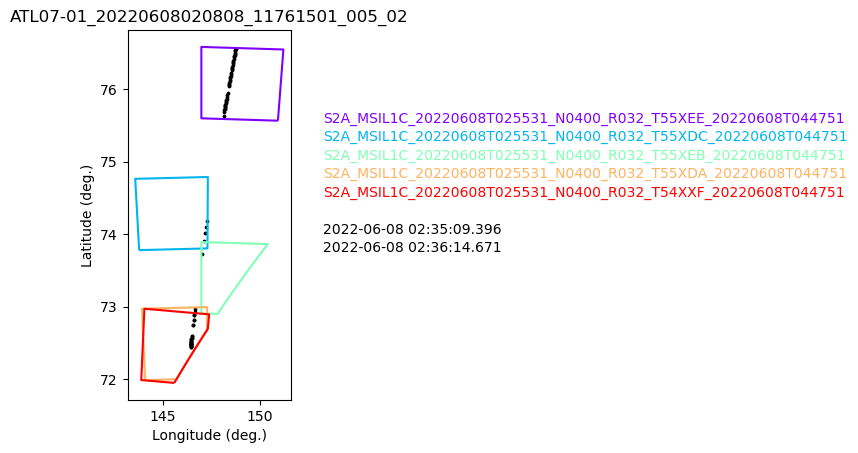

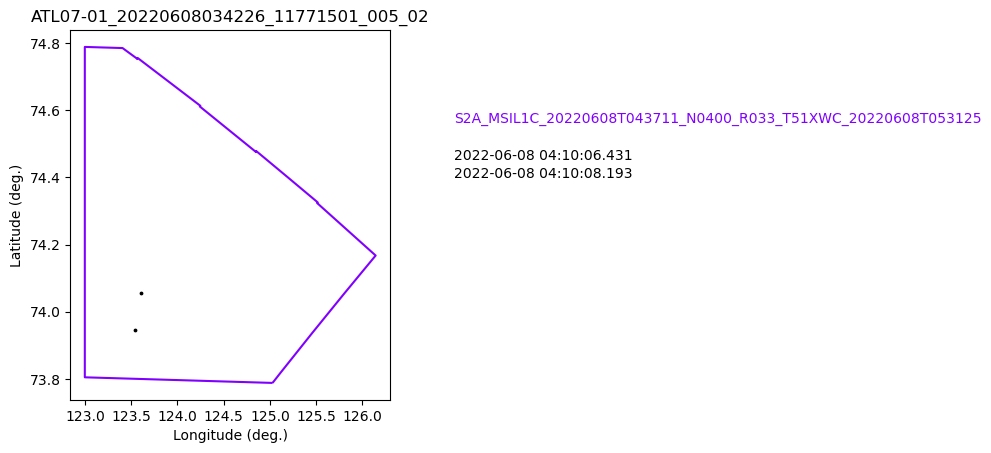

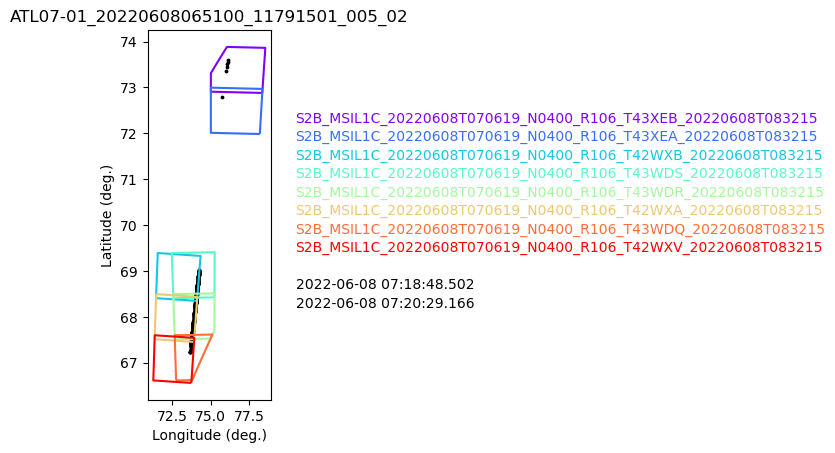

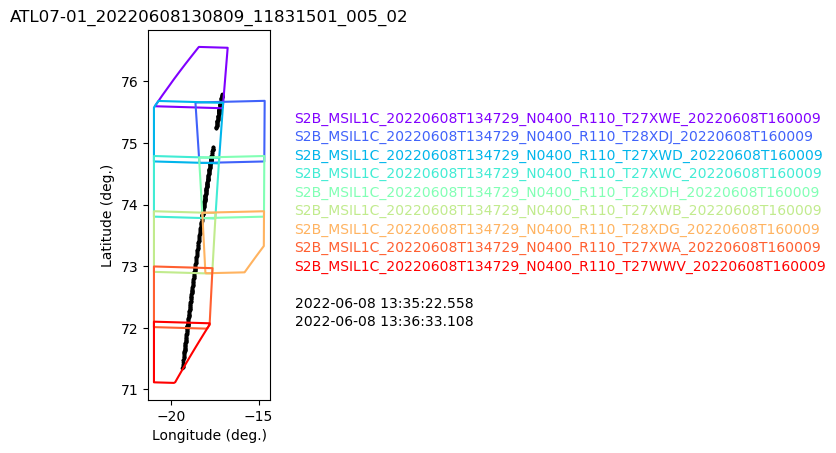

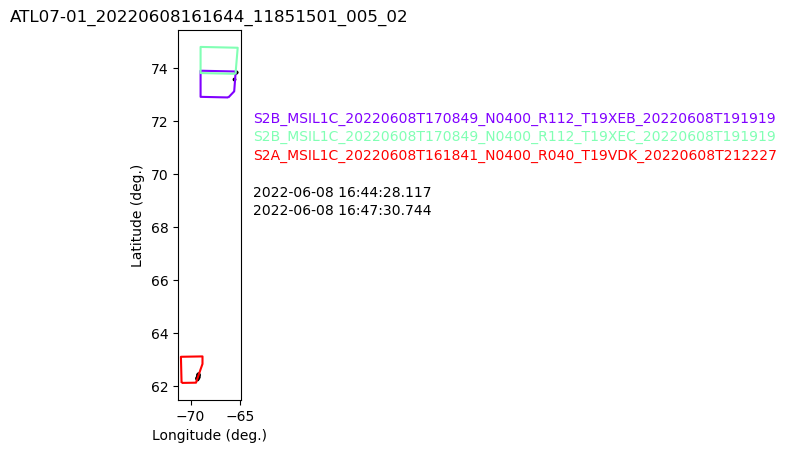

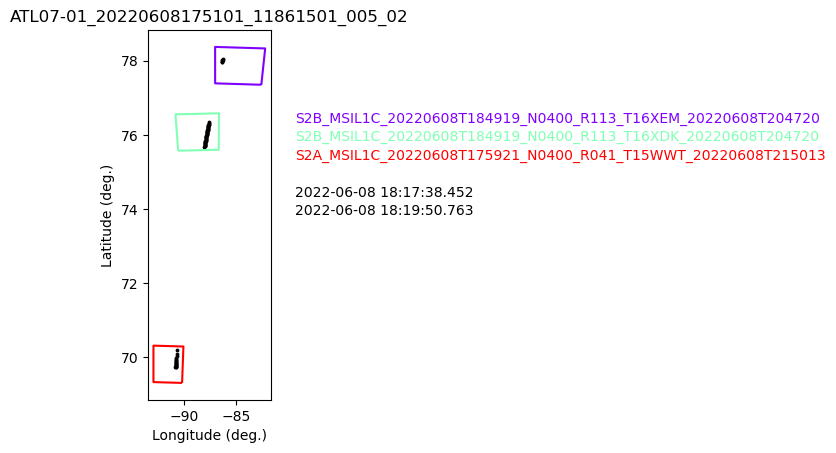

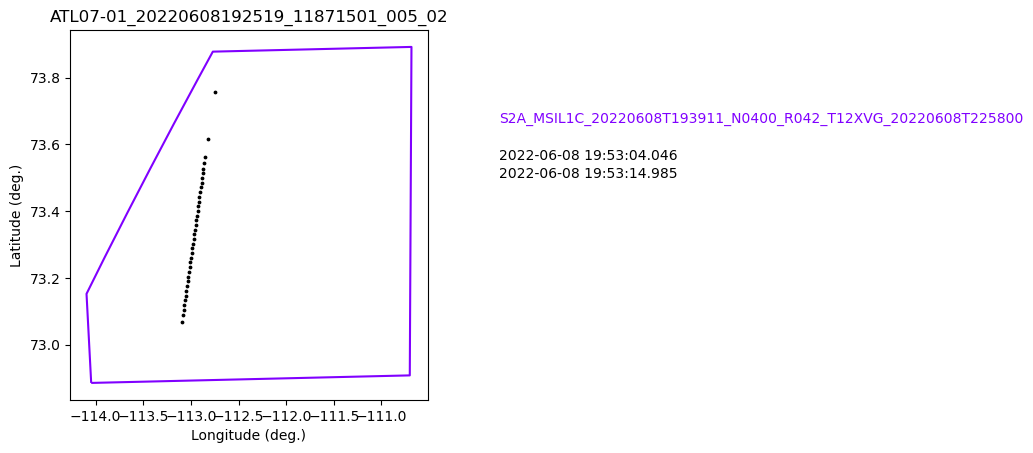

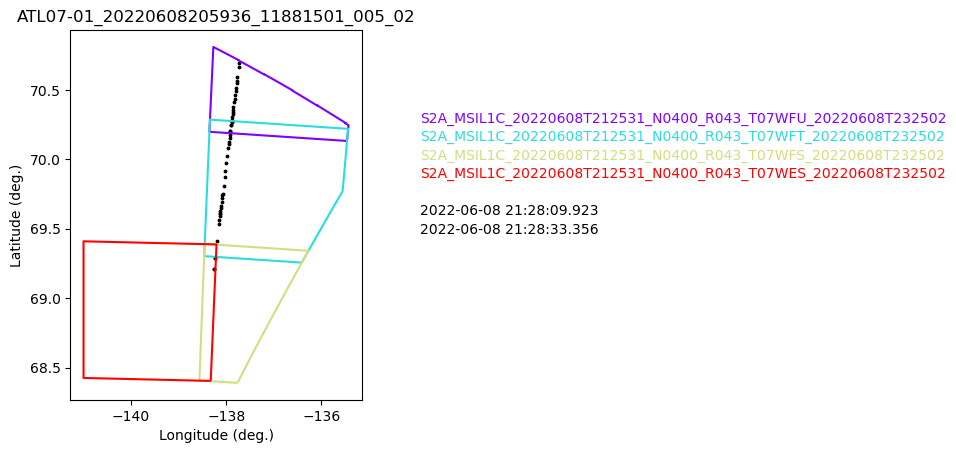

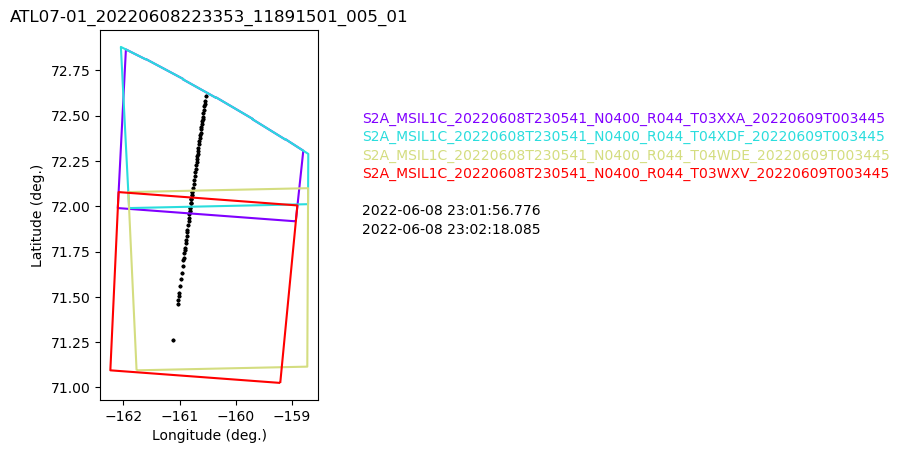

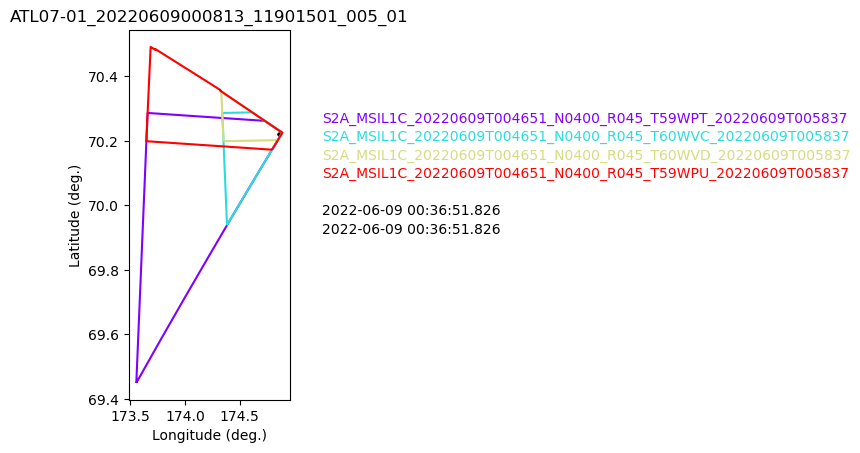

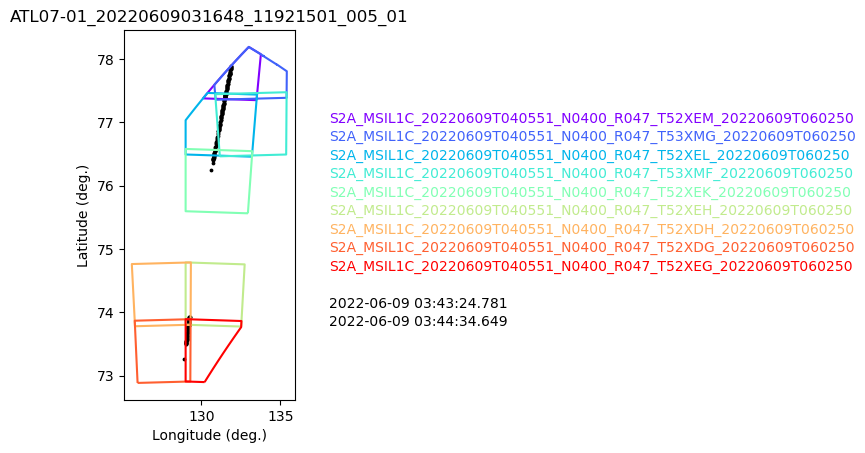

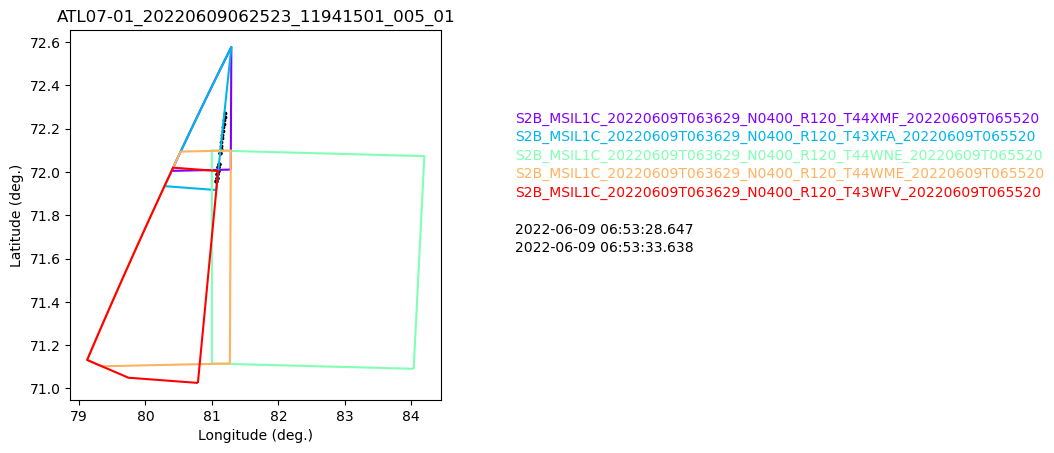

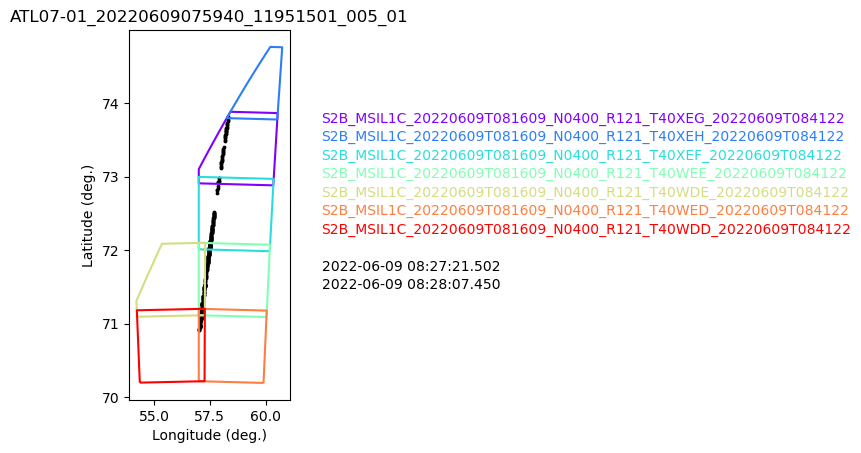

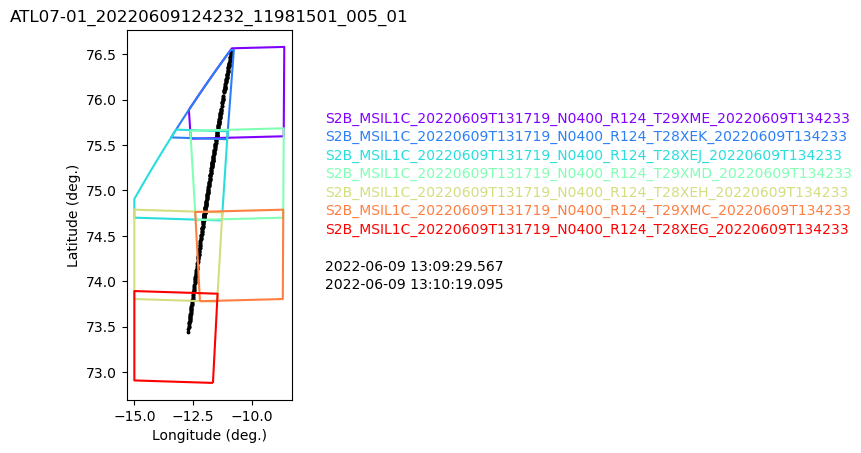

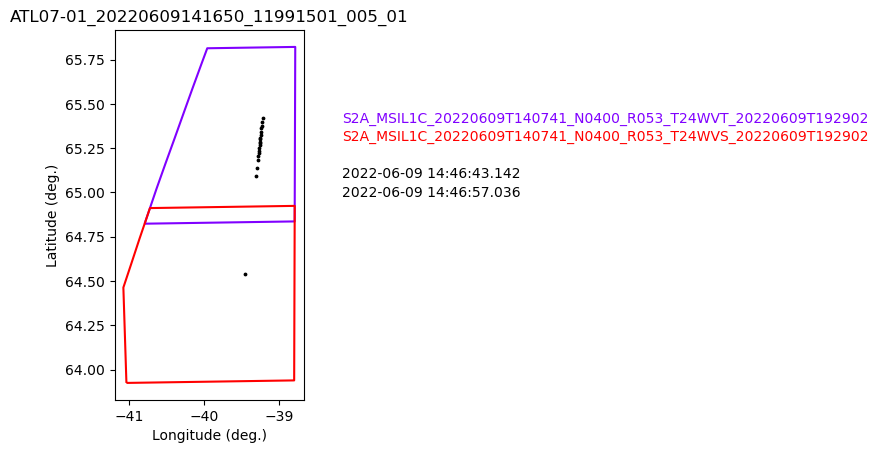

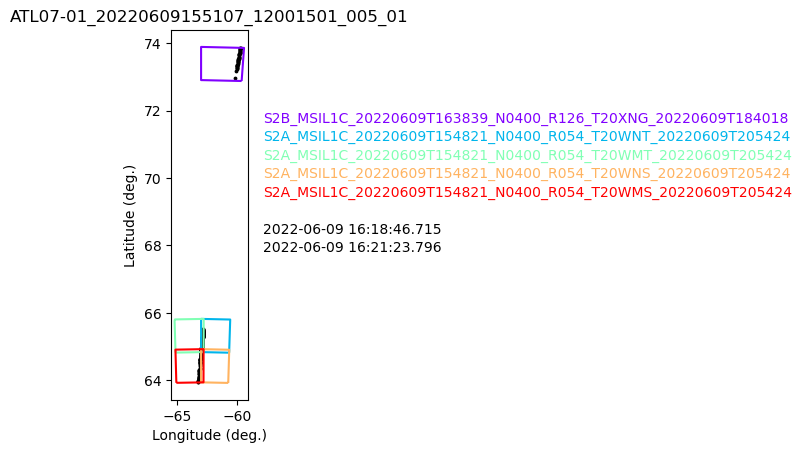

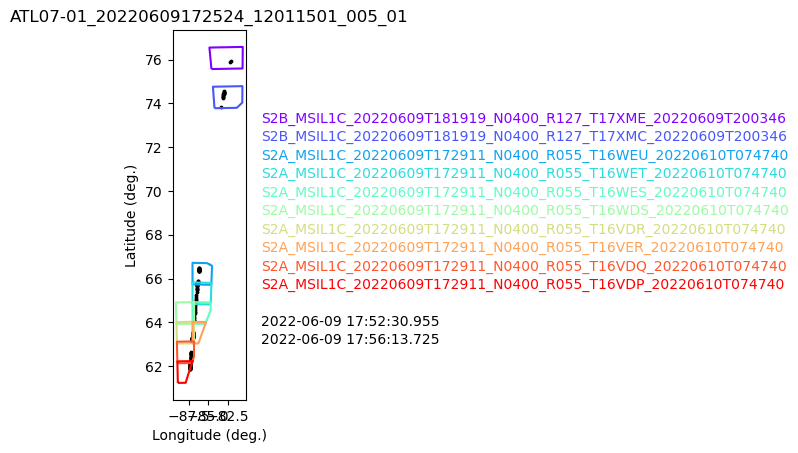

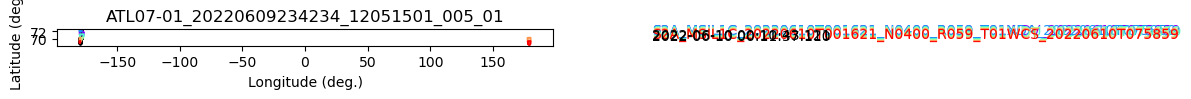

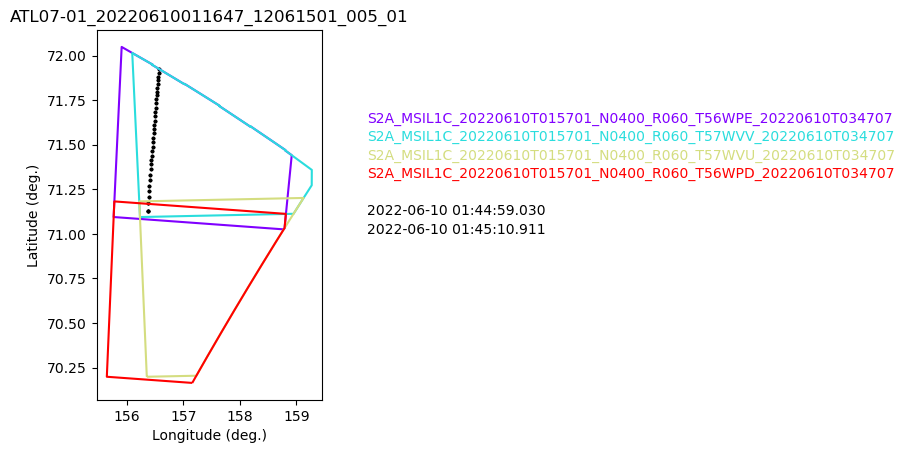

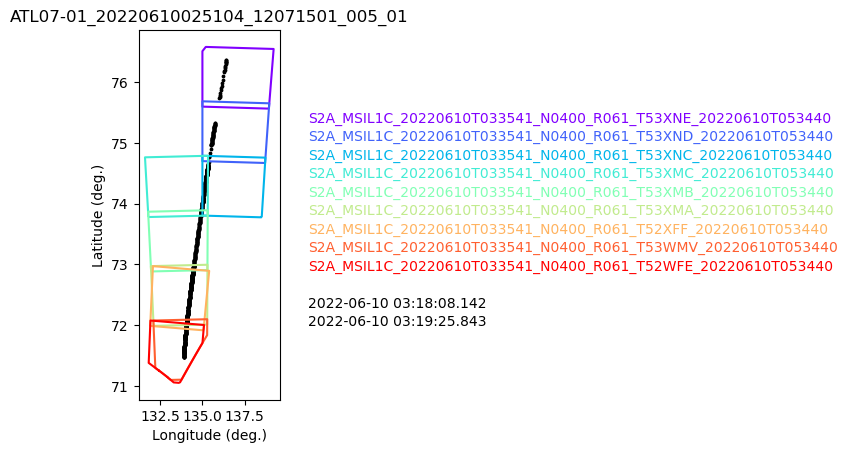

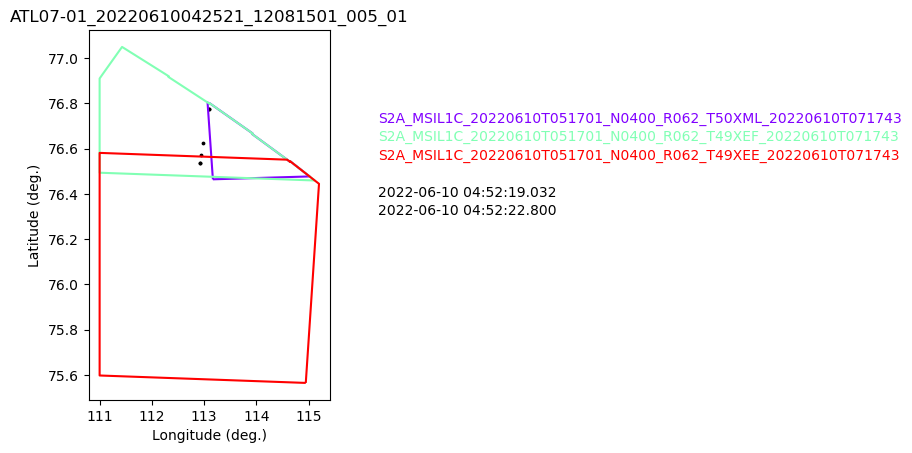

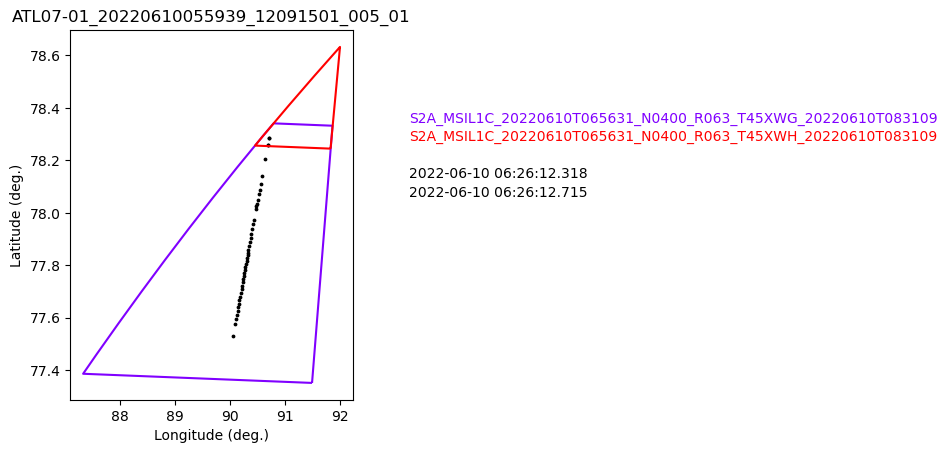

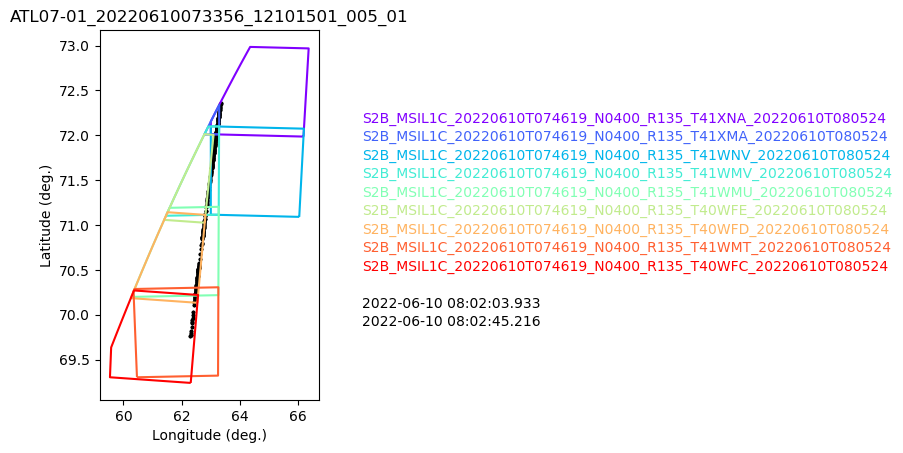

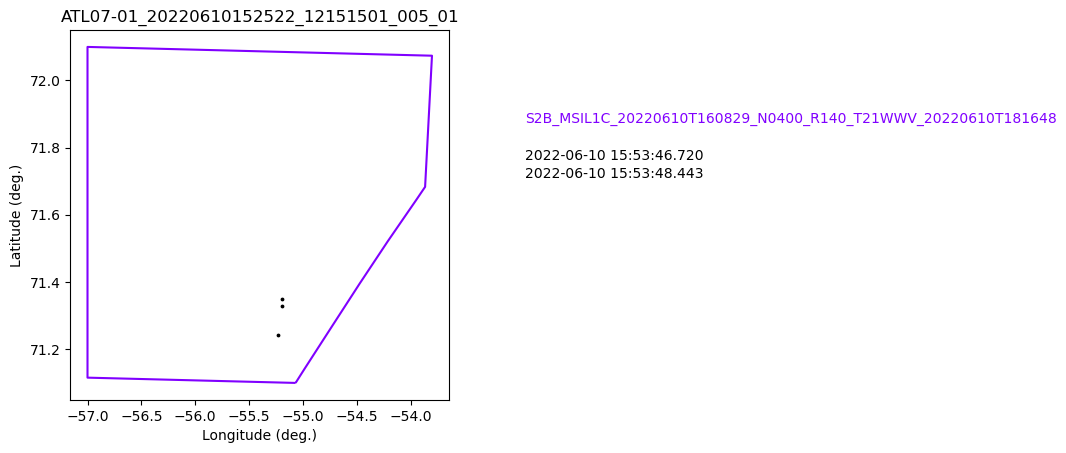

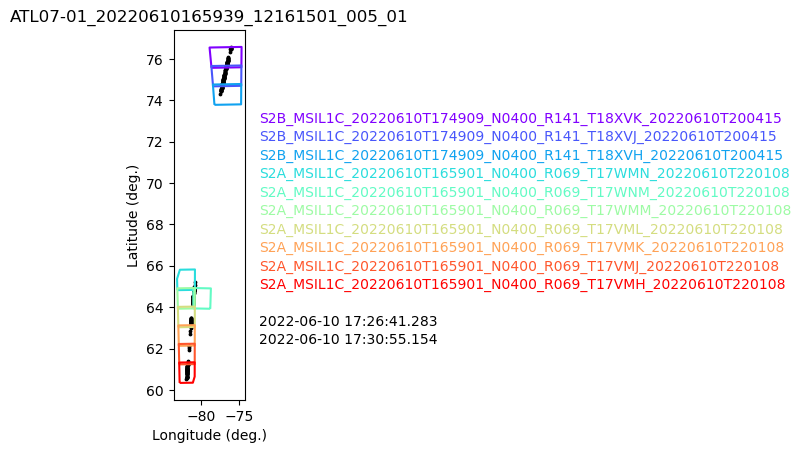

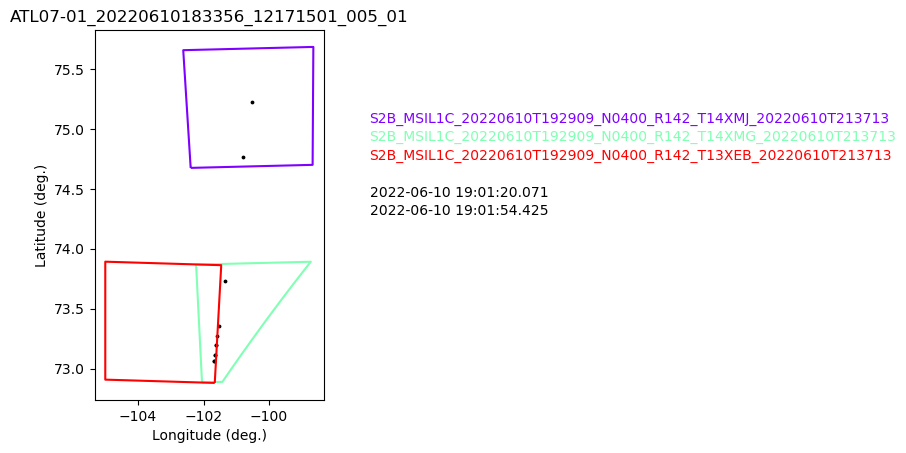

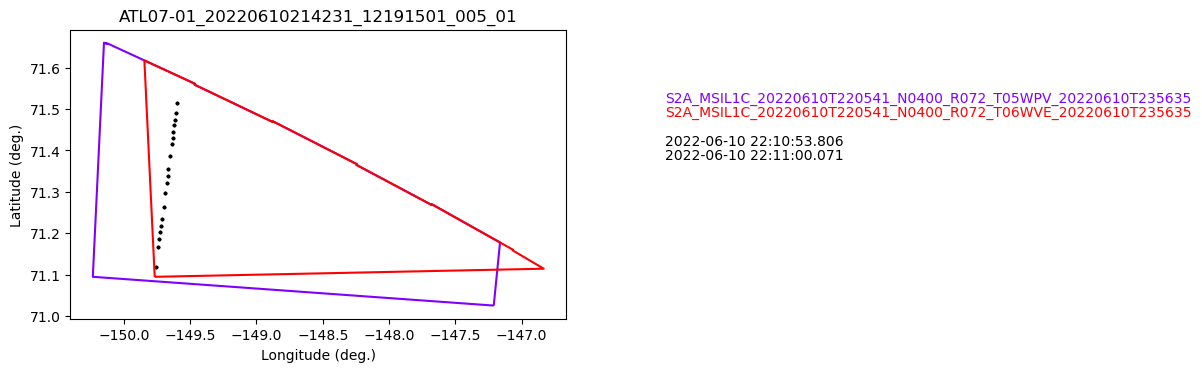

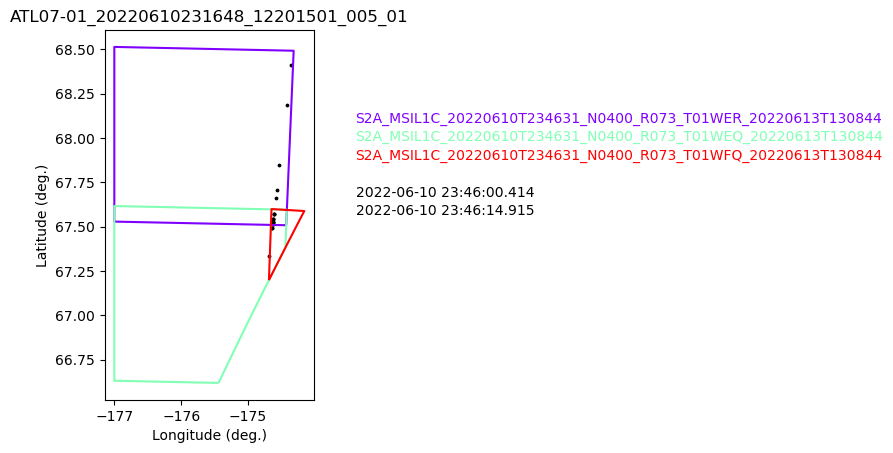

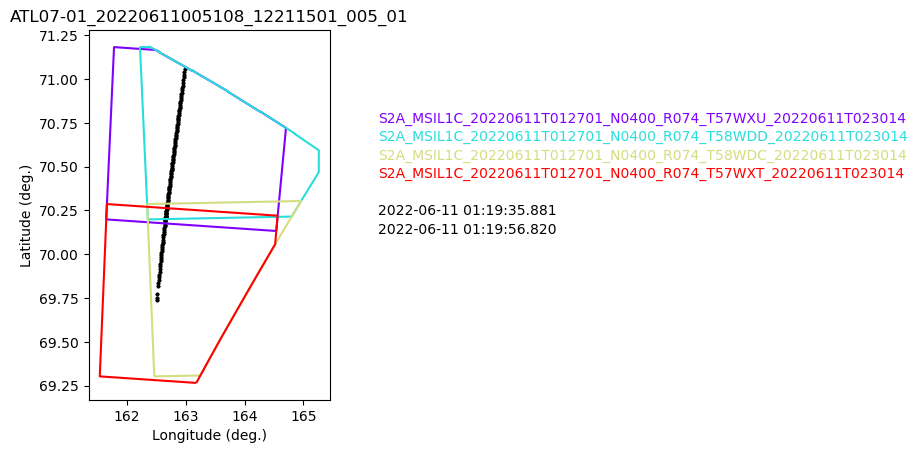

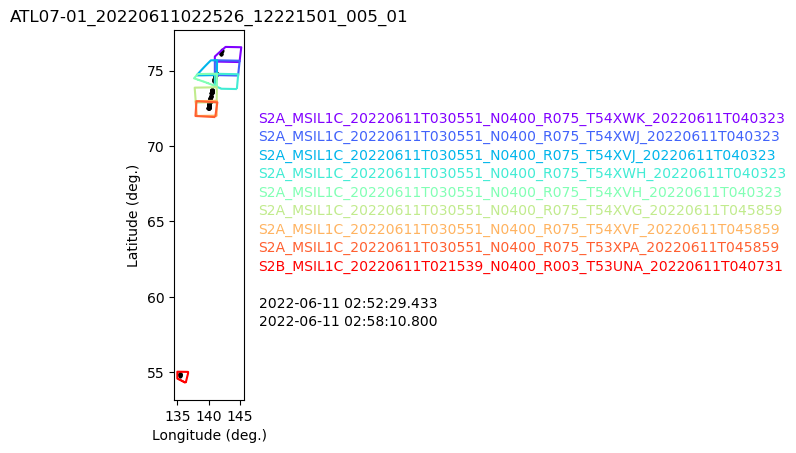

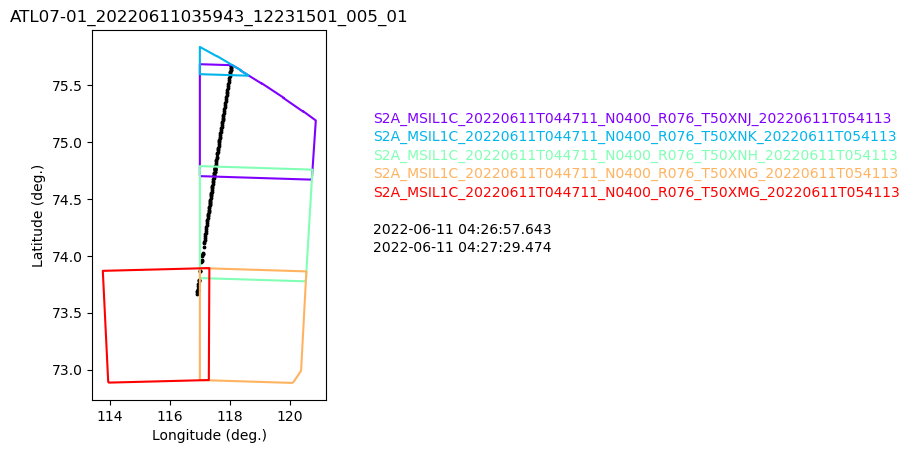

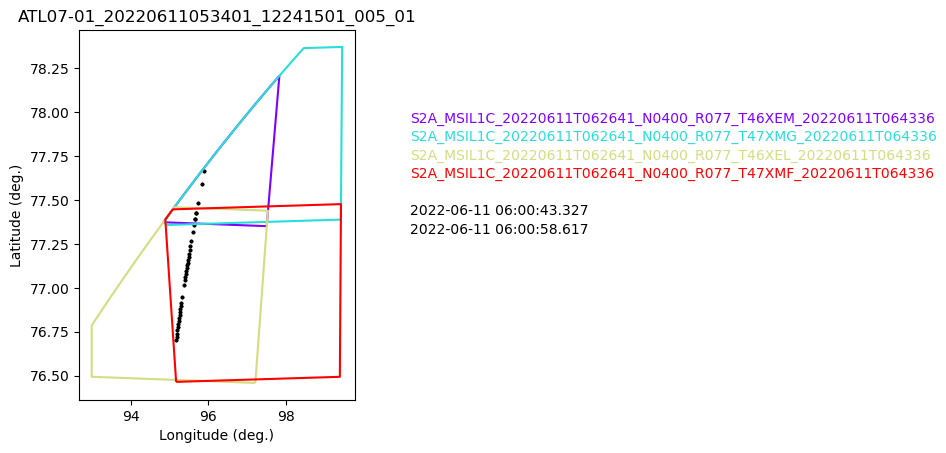

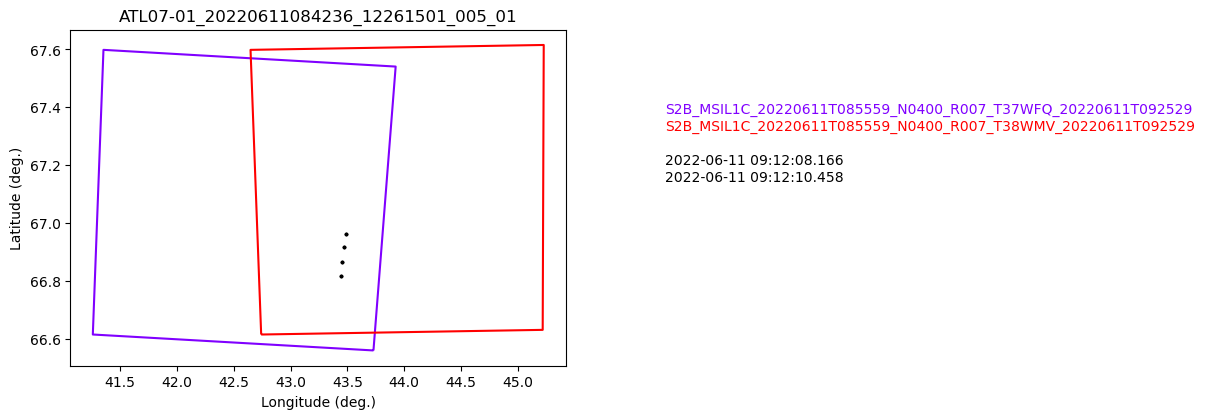

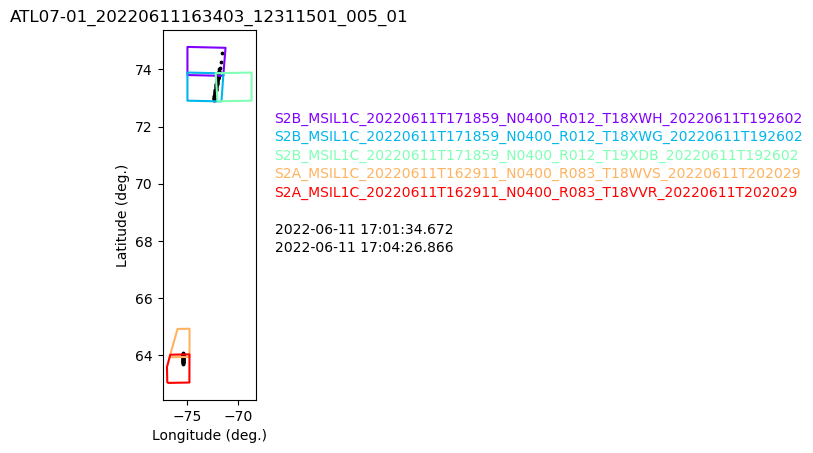

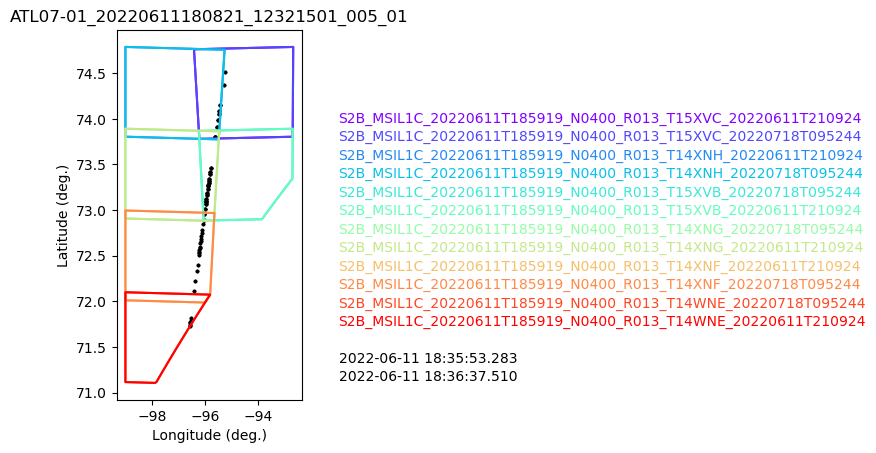

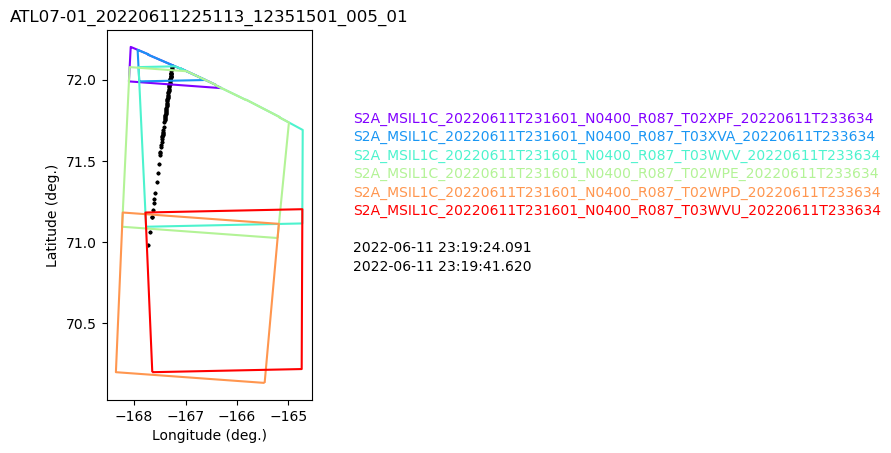

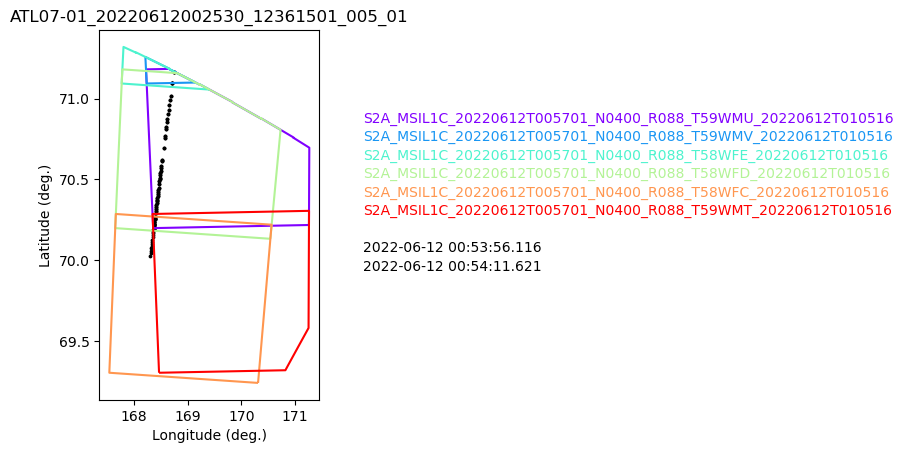

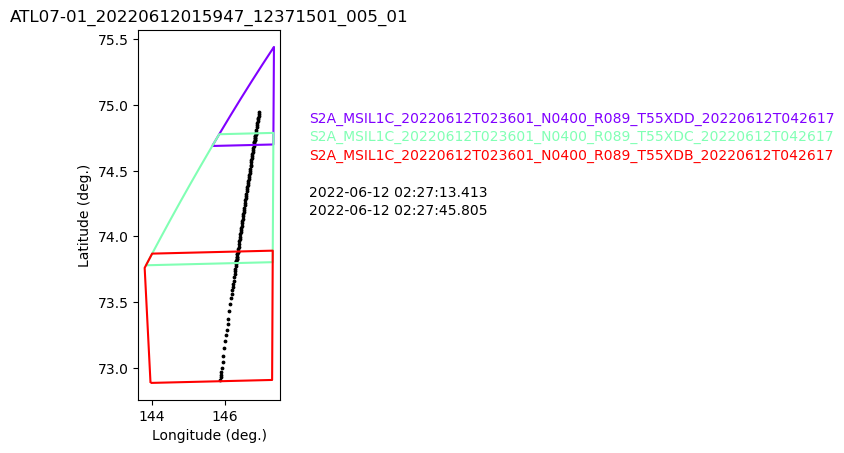

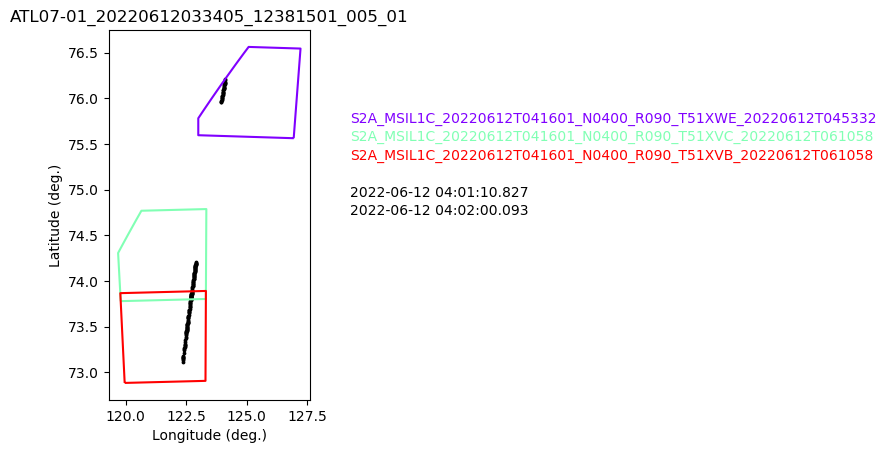

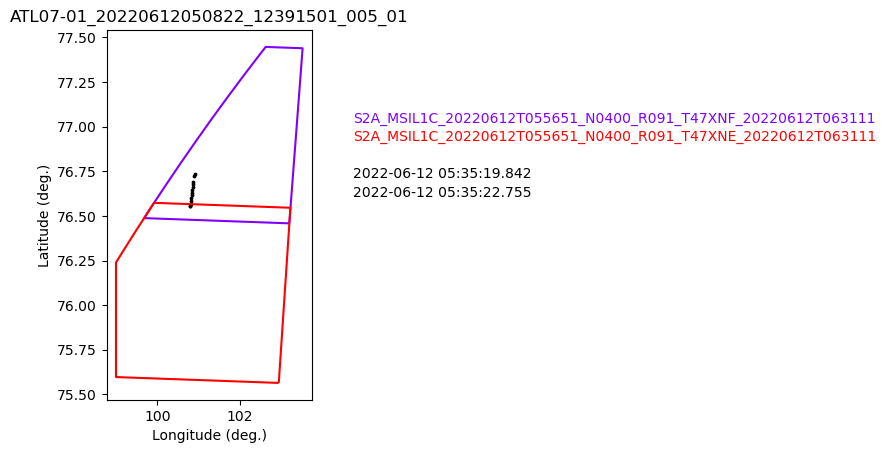

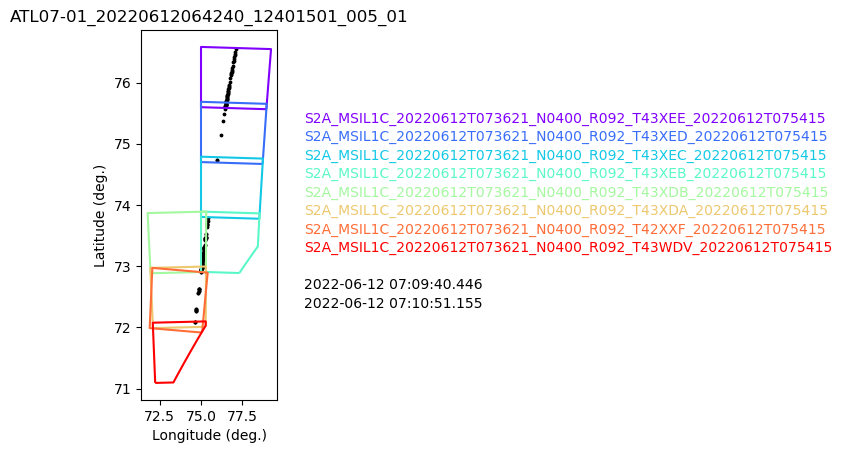

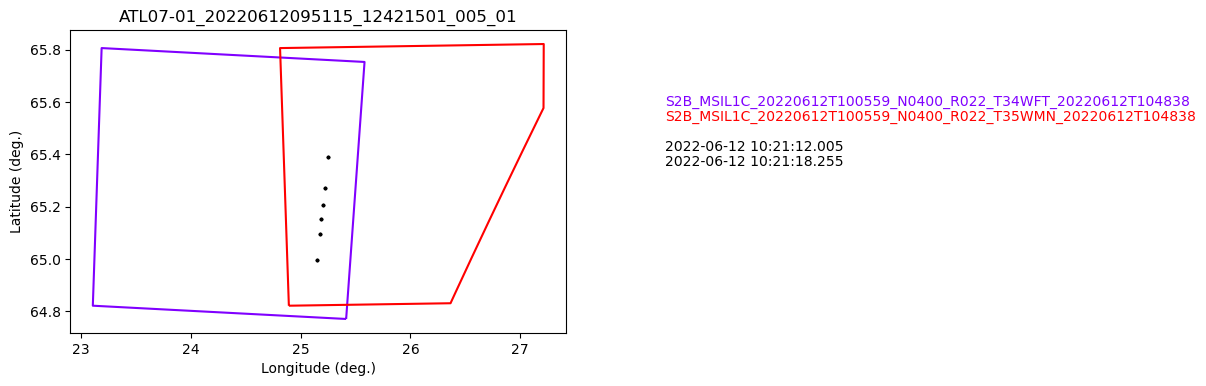

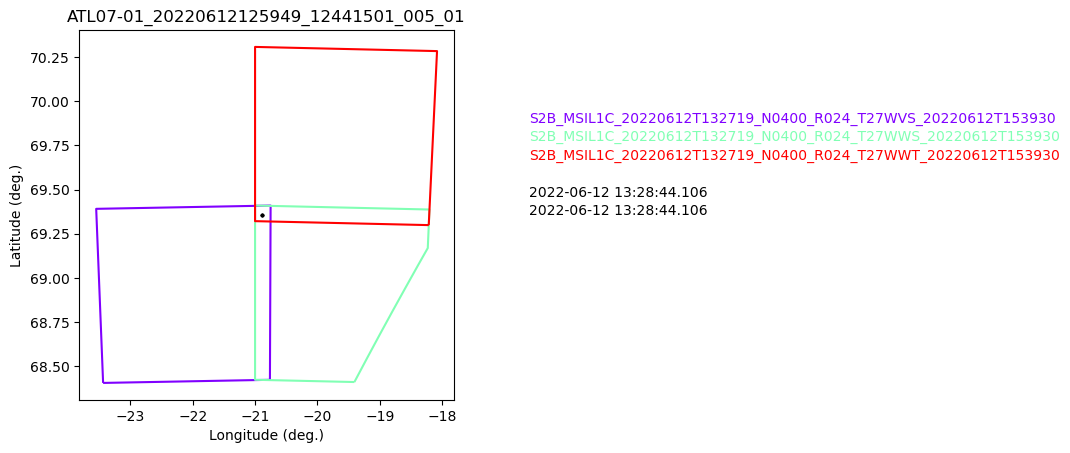

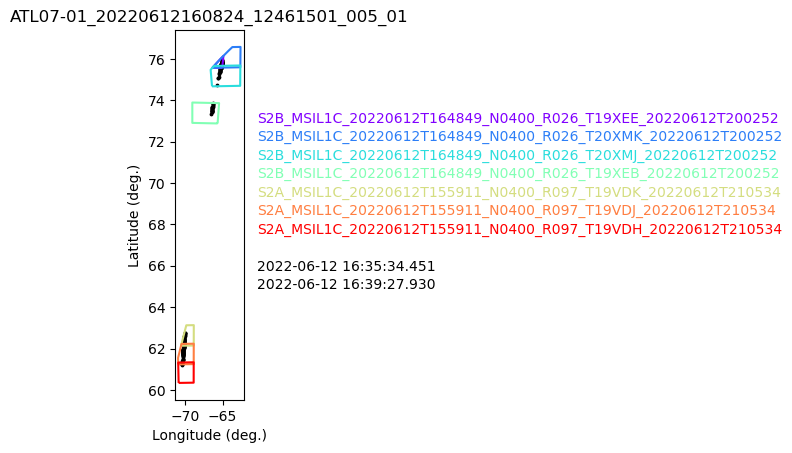

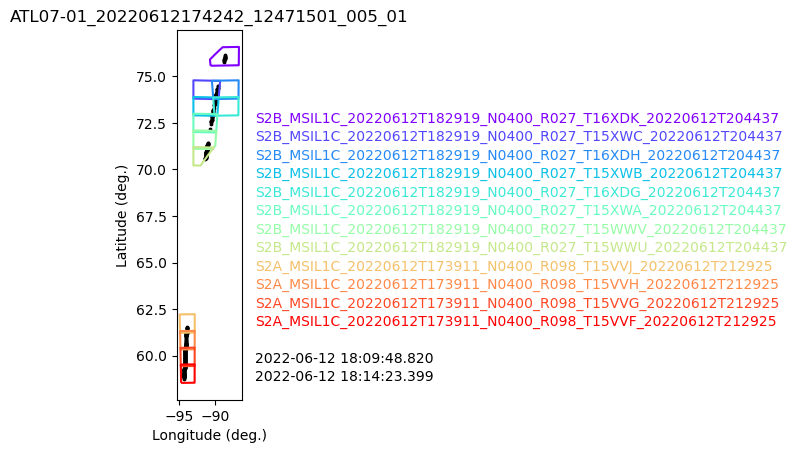

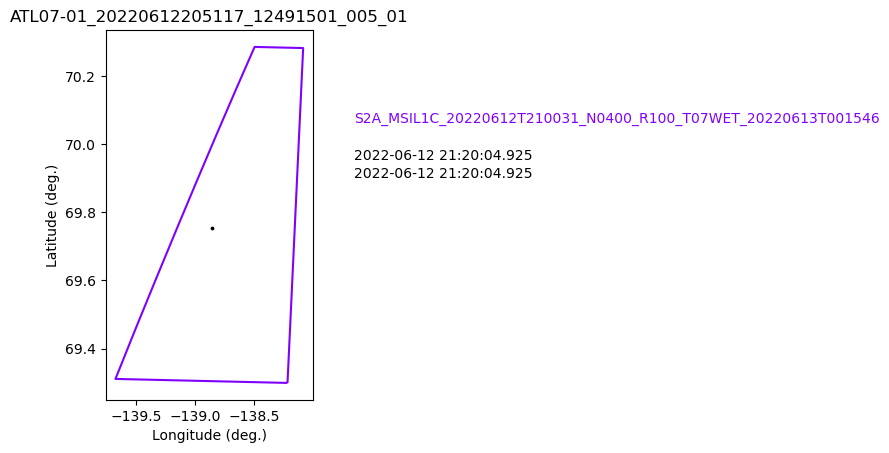

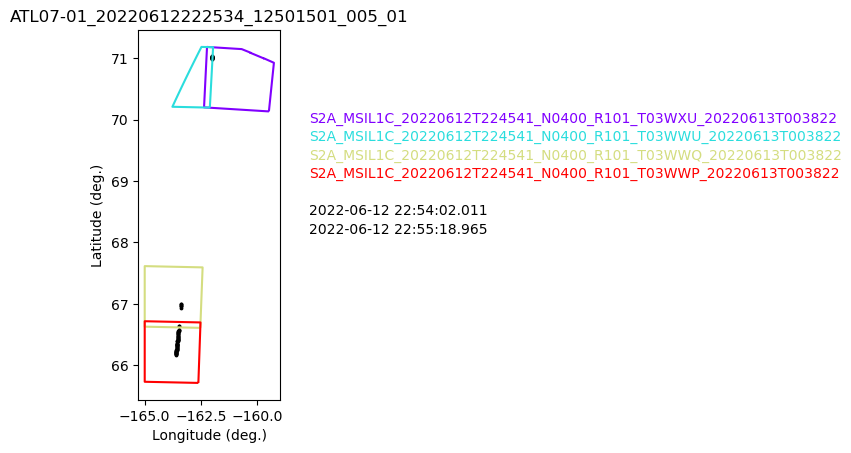

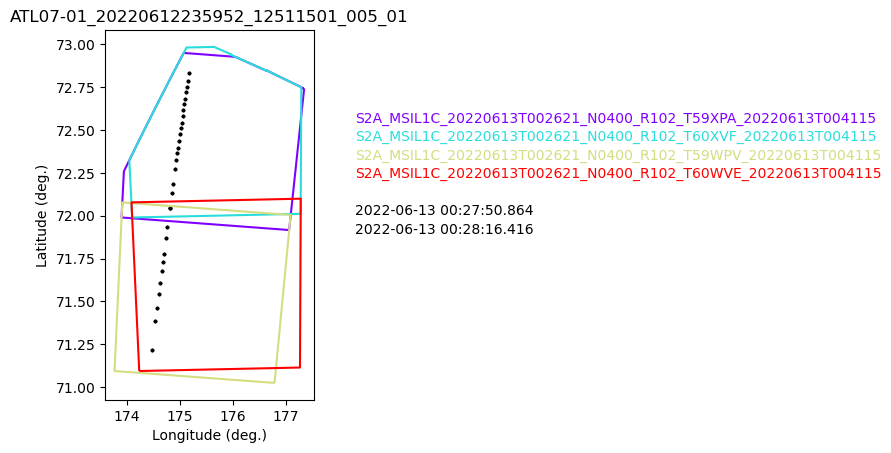

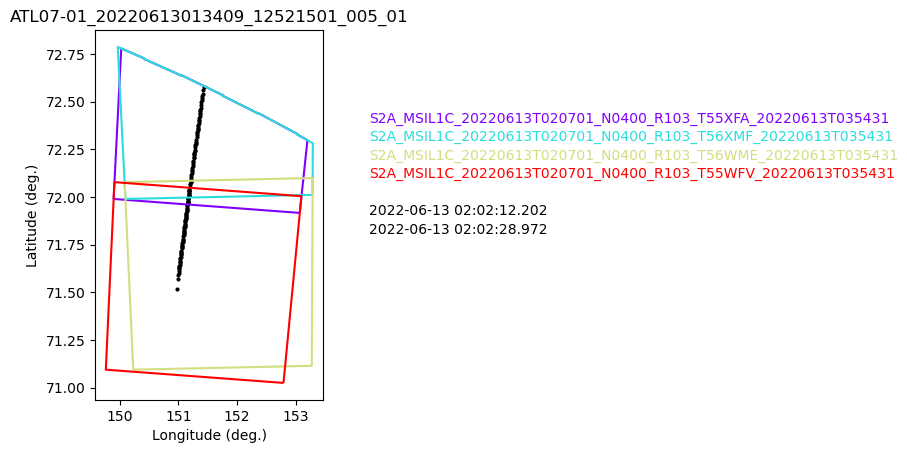

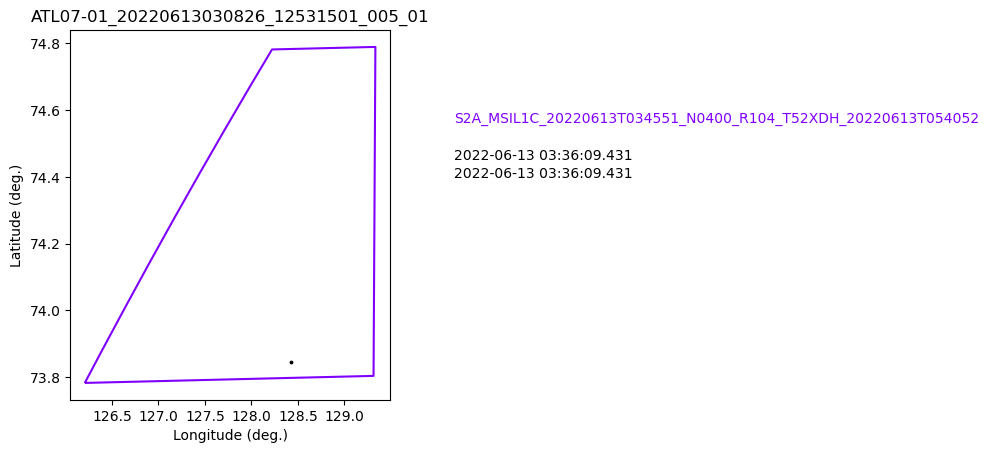

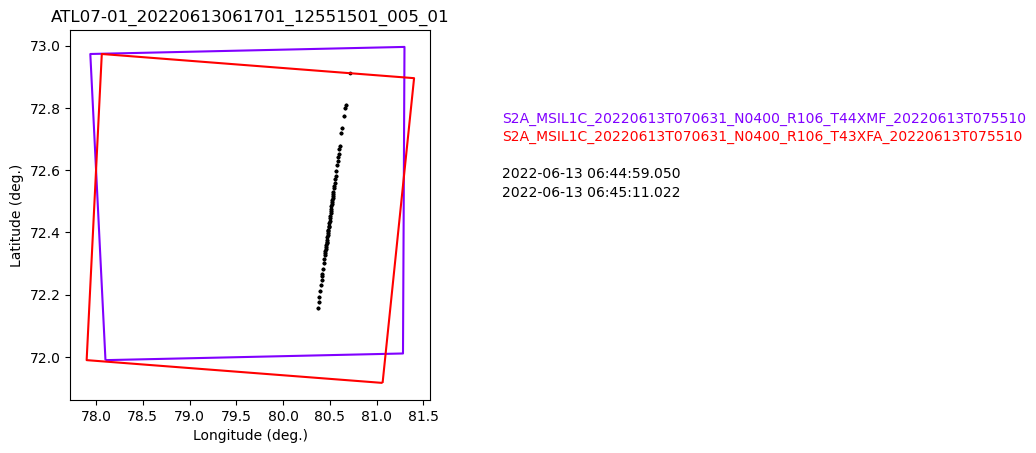

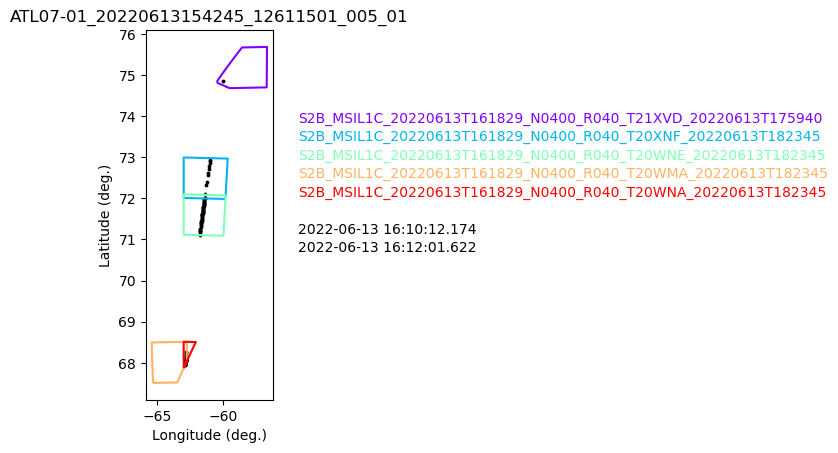

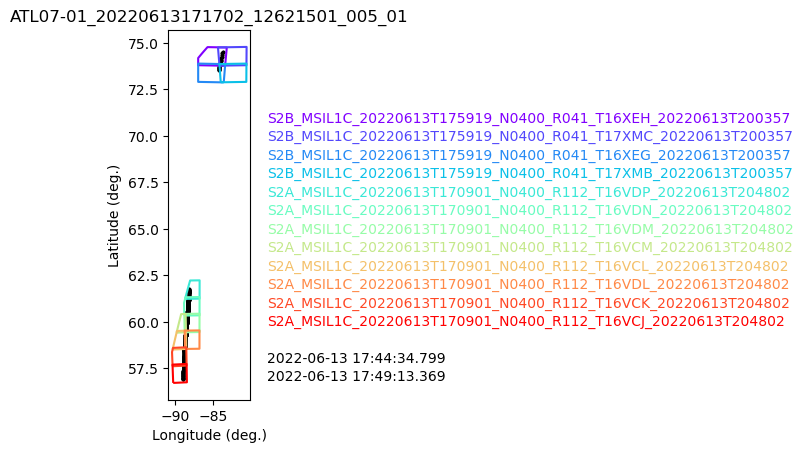

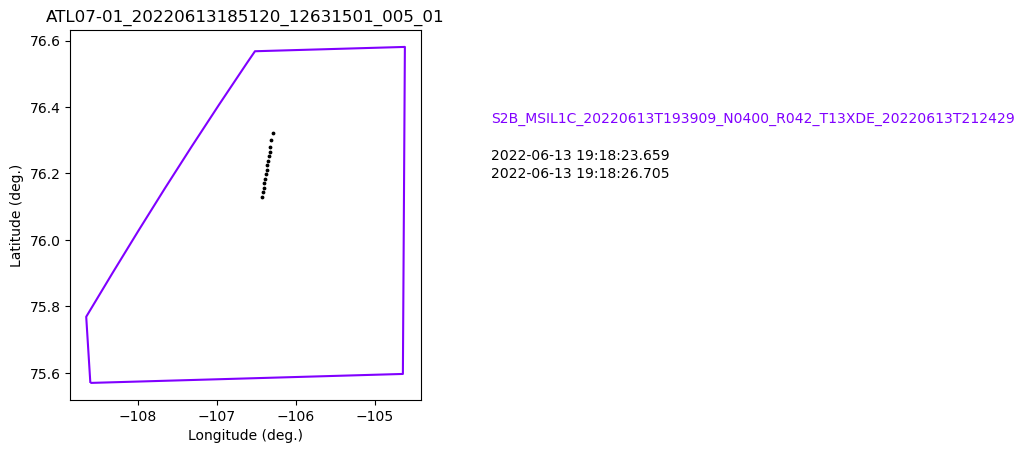

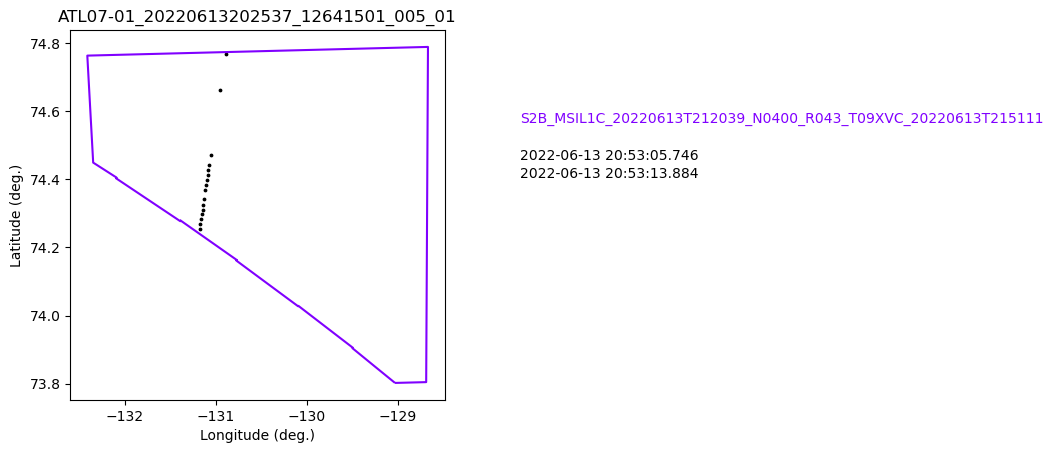

In [4]:
# Credentials for ESA S-2 catalog search

# S2MSI1C: Level-1C data, is both radiometrically and geometrically corrected. This means that the images have been orthorectified, ensuring that they are properly aligned with real-world coordinates and free from distortions due to Earth's curvature and satellite perspective.
# S2MSI2A: Level-2A data, is an atmospherically corrected version of L1C data. It provides bottom-of-atmosphere (BOA) reflectance values, which have been adjusted for the effects of atmospheric gases and aerosols.
# Seems like most folk use S2MSI1C, maybe don't trust the atmospheric corrections??

sentinel2_product='S2MSI1C'
deltatime=30.0
maxcloud=60

lower_lat=-80

username = 'akpetty'
password = 'Icebridge01!'

#sentinelsat.exceptions.UnauthorizedError: Invalid user name or password. Note that account creation and password changes may take up to a week to propagate to the 'https://apihub.copernicus.eu/apihub/' API URL you are using. Consider switching to 'https://scihub.copernicus.eu/dhus/' instead in the mean time.
# Try https://apihub.copernicus.eu/apihub (Marco) or https://scihub.copernicus.eu/dhus/
# Initialize access to API
api = SentinelAPI(username, password, 'https://scihub.copernicus.eu/dhus/')



# ICESat-2 data location

auth = earthaccess.login()
#Query = earthaccess.collection_query().keyword('ICESat-2').cloud_hosted(True)
#collections = Query.fields(['ShortName', 'Version']).get(20)
#print(collections)

Query = earthaccess.granule_query().concept_id(
    'C2153574585-NSIDC_CPRD').temporal("2022-06-08", "2022-06-30").bounding_box(
    -180,-80,180,90)

granules = Query.get()
files = earthaccess.open(granules)

#ATL_filename = files[0]


# Loop over ICESat-2 granules
for ATL_filename in files:
    start = time.time()
    print(ATL_filename)    

    # Check spacecraft orientation and assign string beam IDs
    ATL = h5py.File(ATL_filename, 'r')
    orientation = ATL['/orbit_info/sc_orient'][0]

    # Only use central strong beam locations
    if orientation == 0:
        beamID = 'gt2l'
    elif orientation == 1:
        beamID = 'gt2r'
    else:
        print('Spacecraft orientation not found.')

    # Extract data info from granule
    ATL_start_time = ATL['/ancillary_data/data_start_utc'][0]
    ATL_start = pd.to_datetime(ATL_start_time[:-8].decode('utf-8'), format='%Y-%m-%dT%H:%M:%S')
    ATL_end_time = ATL['/ancillary_data/data_end_utc'][0]
    ATL_end = pd.to_datetime(ATL_end_time[:-8].decode('utf-8'), format='%Y-%m-%dT%H:%M:%S')
    
    ATL_file_name = ATL['/METADATA/DatasetIdentification'].attrs['fileName'].astype(str)[:-3]
    
    GPS_epoch = ATL['ancillary_data/atlas_sdp_gps_epoch'][:]

    # Build dataframe with location of data
    ATL_dF = pd.DataFrame({'Longitude': ATL[beamID + '/sea_ice_segments/longitude'][::200],
                           'Latitude': ATL[beamID + '/sea_ice_segments/latitude'][::200],
                           })
    ATL_dF['coords'] = list(zip(ATL_dF['Longitude'], ATL_dF['Latitude']))
    ATL_dF['coords'] = ATL_dF['coords'].apply(Point)

    GPS_time = ATL[beamID + '/sea_ice_segments/delta_time'][::200] + GPS_epoch
    
    # Use astropy to convert from gps time to datetime
    ATL_tgps = Time(GPS_time, format='gps')
    ATL_utc = ATL_tgps.utc.iso
    ATL_dF['UTC'] = ATL_utc

    ATL_gfd = gpd.GeoDataFrame(ATL_dF, geometry='coords')
    ATL_gfd = ATL_gfd.set_crs(4326, allow_override=True)
    
    end = time.time()
    print(end - start)
    
    #try:
    # Search for Sentinel-2 coincident data
    
    S2_query = api.query(platformname='Sentinel-2', producttype=sentinel2_product,
                         date=(ATL_start - dt.timedelta(minutes=deltatime), ATL_end + dt.timedelta(minutes=deltatime)),
                         cloudcoverpercentage=(0, maxcloud))

    S2_gdf = api.to_geodataframe(S2_query)

    S2_gdf_subset = S2_gdf[(S2_gdf.bounds.miny > lower_lat)]

    points_in_poly = gpd.tools.sjoin(ATL_gfd, S2_gdf_subset)
    #print(points_in_poly)
    
    try:
        # Empty geodataframes threw an exception here
        print('Number of overlapping tiles:', len(points_in_poly['title'].unique()))
    except:
        continue

    if len(points_in_poly['title'].unique()) > 0:

        # Filter products based on the tile ID
        #filtered_products = {k: v for k, v in products.items() if v['tileid'] == tile_id}

        #print('all data:', S2_query)
        #print('subset:', S2_gdf_subset)

        #print(S2_gdf_subset.title)

        # download all results from the search
        #api.download_all(S2_gdf_subset)

        filename = 'S2pairs_'+ATL_file_name
        
        save_path = '/home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/IS2_S2_pair_Arctic/'+sentinel2_product+'/maxcloud'+str(maxcloud)+'_deltatime'+str(int(deltatime))
        
        print('save_path:', save_path)
        
        #if not os.path.exists(cwd+'/'+sentinel2_product):
        #     os.mkdir(cwd+'/'+sentinel2_product)

        #if not os.path.exists(cwd+'/'+sentinel2_product+'/maxcloud'+str(maxcloud)+'_deltatime'+str(int(deltatime))):
        #     os.mkdir(cwd+'/'+sentinel2_product+'/maxcloud'+str(maxcloud)+'_deltatime'+str(int(deltatime)))

        if not os.path.exists(save_path):
             os.mkdir(save_path)
        if not os.path.exists(save_path+'/'+filename):
            os.mkdir(save_path+'/'+filename)

        
        f = open(save_path+"/"+filename + "/" + filename+".txt", 'a')

        fig, ax = plt.subplots(1, 1)

        color = iter(plt.cm.rainbow(np.linspace(0, 1, len(points_in_poly['title'].unique()))))
        y_shift = 0.8

        for granule in points_in_poly['title'].unique():
            print(granule)
            c = next(color)
            y_shift = y_shift -0.05

            S2_gdf_subset[S2_gdf_subset['title'] == granule].boundary.plot(ax=ax, color=c)
            plt.text(1.2, y_shift, str(granule), transform=ax.transAxes, color=c)

        points_in_poly.plot(ax=ax, markersize=3, color='k', marker='o')
        plt.title(ATL_file_name)
        plt.xlabel('Longitude (deg.)')
        plt.ylabel('Latitude (deg.)')

        plt.text(1.2, y_shift -0.10, points_in_poly.iloc[0].UTC, transform=ax.transAxes, color='k')
        plt.text(1.2, y_shift -0.15, points_in_poly.iloc[-1].UTC, transform=ax.transAxes, color='k')

        plt.savefig(save_path+"/"+filename + "/" + filename+".png", bbox_inches='tight', dpi=100)

        f.write(save_path+"/"+filename + '\n')
        f.write('\n')
        f.write('Lat min: ' + str(min(points_in_poly.Latitude)) + '\n')
        f.write('Lat max: ' + str(max(points_in_poly.Latitude)) + '\n')
        f.write('Time start: ' + points_in_poly.iloc[0].UTC + '\n')
        f.write('Time end: ' + points_in_poly.iloc[-1].UTC + '\n')
        f.write('\n')
        f.write(str(points_in_poly['title'].unique()) + '\n')
        f.write('\n')
        f.write(str(points_in_poly['summary'].unique()) + '\n')
        f.write('\n')
        f.write(str(points_in_poly['link'].unique()) + '\n')
        f.write('\n')
        f.write(str(points_in_poly['link_icon'].unique()) + '\n')
        f.write('\n')

        f.close()

        for title, uuid in zip(points_in_poly['title'].unique(), points_in_poly['uuid'].unique()):
            #print('saving quiklook tile / uuid:', title, uuid)
            #save_quicklook(uuid, username, password, save_path, title)

            print('Try downloading quicklook scenes using the API')
            try:
                api.download_quicklook(uuid, directory_path=save_path+"/"+filename+"/")
            except:
                print('Error downloading quicklook')
                continue

            print('Try downloading full scenes using the API')
            product_info = api.get_product_odata(uuid)
 
            is_online = api.is_online(uuid)

            if is_online:
                print(f'Product {uuid} is online. Starting download.')
                try:
                    # Added checksum=False as a weird exception related to the metadata
                    # https://github.com/sentinelsat/sentinelsat/issues/467
                    api.download(uuid, directory_path=save_path+"/"+filename+"/", checksum=False)
                except:
                    continue
            else:
                print(f'Product {uuid} is not online.')
                try:
                    api.trigger_offline_retrieval(uuid)
                except:
                    continue    

            
            #api.download(uuid, directory_path=save_path)

    #except:
    #    print('Some issue with the Sentinel-2 catalog has occurred, skipping current granule.')
